# Kaggle GI Tract Train

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create simple model for first submission - done
* Add some augmentation transforms (https://github.com/albumentations-team/albumentations)
    * rotation (10 deg)
    * resize
* Extend training epochs

* remove bad data https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/321979



* Go to 2.5 D method  - check if providing repeat image vs padding is better when making 2.5 d image

* Go to 3D method




* add Hausdorff metric https://github.com/mavillan/py-hausdorff
https://www.kaggle.com/code/carnozhao/tract-competiton-metrics



In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

from tqdm.notebook import tqdm

import albumentations as A
from torchvision import transforms



#DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

MODEL_FOLDER = DATASET_FOLDER/"kaggle models"
os.makedirs(MODEL_FOLDER, exist_ok=True)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

model_name_base = "Unet-6"

# Data

## Process the Metadata

In [2]:
df2d = pd.read_csv(DATASET_FOLDER/"df2d_metadata.csv",index_col = [0])
display(df2d.head())

large_bowel small_bowel stomach                        id case_id_str  \
0         NaN         NaN     NaN  case101_day20_slice_0001     case101   
1         NaN         NaN     NaN  case101_day20_slice_0002     case101   
2         NaN         NaN     NaN  case101_day20_slice_0003     case101   
3         NaN         NaN     NaN  case101_day20_slice_0004     case101   
4         NaN         NaN     NaN  case101_day20_slice_0005     case101   

   case_id day_num_str  day_num    slice_id  slice_num  \
0      101       day20       20  slice_0001          1   
1      101       day20       20  slice_0002          2   
2      101       day20       20  slice_0003          3   
3      101       day20       20  slice_0004          4   
4      101       day20       20  slice_0005          5   

                                    match  \
0  case101/case101_day20/scans/slice_0001   
1  case101/case101_day20/scans/slice_0002   
2  case101/case101_day20/scans/slice_0003   
3  case101/case101_day20/scans/slice_0004   
4  case101/case101_day20/scans/slice_0005   

                                             subpath  \
0  case101/case101_day20/scans/slice_0001_266_266...   
1  case101/case101_day20/scans/slice_0002_266_266...   
2  case101/case101_day20/scans/slice_0003_266_266...   
3  case101/case101_day20/scans/slice_0004_266_266...   
4  case101/case101_day20/scans/slice_0005_266_266...   

                           filename  im_height  im_width  im_pixel_height  \
0  slice_0001_266_266_1.50_1.50.png        266       266              1.5   
1  slice_0002_266_266_1.50_1.50.png        266       266              1.5   
2  slice_0003_266_266_1.50_1.50.png        266       266              1.5   
3  slice_0004_266_266_1.50_1.50.png        266       266              1.5   
4  slice_0005_266_266_1.50_1.50.png        266       266              1.5   

   im_pixel_width  slice_thickness  segmentations  fold  
0             1.5              3.0          False   4.0  
1             1.5              3.0          False   4.0  
2             1.5              3.0          False   4.0  
3             1.5              3.0          False   4.0  
4             1.5              3.0          False   4.0

In [3]:
df2d.columns

Index(['large_bowel', 'small_bowel', 'stomach', 'id', 'case_id_str', 'case_id',
       'day_num_str', 'day_num', 'slice_id', 'slice_num', 'match', 'subpath',
       'filename', 'im_height', 'im_width', 'im_pixel_height',
       'im_pixel_width', 'slice_thickness', 'segmentations', 'fold'],
      dtype='object')

### Get pixel scaling info from 3D scans

In [4]:
pil_to_tensor = transforms.ToTensor()

In [5]:
def image_max(subpath):
    img_path = TRAIN_FOLDER/subpath
    img = pil_to_tensor(Image.open(img_path))
    #stat = img.max().item()
    stat = (img.flatten()*1.0).quantile(0.75).item()
    return stat

In [6]:
#find the max pixel intensity for each image
df2d['max'] = df2d['subpath'].apply(image_max)

In [7]:
#group by the slice (same case_id and day_num)
#make a transform
d = df2d.groupby(['case_id' ,'day_num'])['max'].transform('max')

In [8]:
#add to the dataframe
df2d['max_img'] = d

In [9]:
df25d = df2d

### Identify neighboring slices

In [10]:
def add_neighboring_slices(df, channels=3, stride=2):    

    for i in range(channels):
        shift = (i - channels//2)*stride
        print("channel:",i, "shift:",shift)
        df[f'subpath_{i:02}'] = df.groupby(['case_id','day_num'])['subpath'].shift(-shift).fillna(value='')
    df['subpaths'] = df[[f'subpath_{i:02d}' for i in range(channels)]].values.tolist()

In [11]:
add_neighboring_slices(df25d, channels=3, stride=2)

channel: 0 shift: -2
channel: 1 shift: 0
channel: 2 shift: 2


In [12]:
df25d[['subpath_00','subpath_01','subpath_02']]

subpath_00  \
0                                                          
1                                                          
2      case101/case101_day20/scans/slice_0001_266_266...   
3      case101/case101_day20/scans/slice_0002_266_266...   
4      case101/case101_day20/scans/slice_0003_266_266...   
...                                                  ...   
38491  case9/case9_day22/scans/slice_0138_360_310_1.5...   
38492  case9/case9_day22/scans/slice_0139_360_310_1.5...   
38493  case9/case9_day22/scans/slice_0140_360_310_1.5...   
38494  case9/case9_day22/scans/slice_0141_360_310_1.5...   
38495  case9/case9_day22/scans/slice_0142_360_310_1.5...   

                                              subpath_01  \
0      case101/case101_day20/scans/slice_0001_266_266...   
1      case101/case101_day20/scans/slice_0002_266_266...   
2      case101/case101_day20/scans/slice_0003_266_266...   
3      case101/case101_day20/scans/slice_0004_266_266...   
4      case101/case101_day20/scans/slice_0005_266_266...   
...                                                  ...   
38491  case9/case9_day22/scans/slice_0140_360_310_1.5...   
38492  case9/case9_day22/scans/slice_0141_360_310_1.5...   
38493  case9/case9_day22/scans/slice_0142_360_310_1.5...   
38494  case9/case9_day22/scans/slice_0143_360_310_1.5...   
38495  case9/case9_day22/scans/slice_0144_360_310_1.5...   

                                              subpath_02  
0      case101/case101_day20/scans/slice_0003_266_266...  
1      case101/case101_day20/scans/slice_0004_266_266...  
2      case101/case101_day20/scans/slice_0005_266_266...  
3      case101/case101_day20/scans/slice_0006_266_266...  
4      case101/case101_day20/scans/slice_0007_266_266...  
...                                                  ...  
38491  case9/case9_day22/scans/slice_0142_360_310_1.5...  
38492  case9/case9_day22/scans/slice_0143_360_310_1.5...  
38493  case9/case9_day22/scans/slice_0144_360_310_1.5...  
38494                                                     
38495                                                     

[38496 rows x 3 columns]

In [13]:
#df25d.to_csv(DATASET_FOLDER/"df25d_metadata.csv")

## Create a Pytorch Dataset

In [14]:
#df25d = pd.read_csv(DATASET_FOLDER/"df25d_metadata.csv",index_col = [0])

In [15]:
df25d[['subpath_00','subpath_01','subpath_02']]=df25d[['subpath_00','subpath_01','subpath_02']].fillna('')

In [16]:
class Dataset_2_5_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, joint_transform=None, image_transform=None, mask_transform=None,ret_idx=False):
        self.df = df
        self.path = path
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.ret_idx = ret_idx
        self.pil_to_tensor = transforms.ToTensor()
        
        

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        
        
        
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #img = np.array(Image.open(img_path))*1.0 # L,W,C
        
        #scale image using stats from whole 3D image
        img = img / (row['max_img']*5) # factor to make sure we don't clip
        #print(row['max_img'])
        #img = Image.open(img_path)
        #print(img.shape)
        #print(img.dtype)
        
        img3 = torch.zeros((3, img.shape[1], img.shape[2]),dtype=torch.float32)
        mask = torch.zeros((3, img.shape[1], img.shape[2]))
        
        img3[1,:,:] = img
        
        if len(row.subpath_00) > 0:
            img = self.pil_to_tensor(Image.open(self.path/row.subpath_00))
            img = img / (row['max_img']*5) # factor to make sure we don't clip
            img3[0,:,:] = img
 
        if len(row.subpath_02) > 0:
            img = self.pil_to_tensor(Image.open(self.path/row.subpath_02))
            img = img / (row['max_img']*5) # factor to make sure we don't clip
            img3[2,:,:] = img
            
        
        
        
        if self.image_transform:
            img3 = self.image_transform(img3)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        

            
        if self.mask_transform:
            mask = self.mask_transform(mask)       
        
        
        if self.joint_transform:            
            #image_stack = torch.cat([img3, mask], dim=0)
            #image_stack = self.joint_transform(image_stack)
            #img = image_stack[0:3]
            #mask = image_stack[3:6]
            image_numpy = rearrange(img3.numpy(),'c h w -> h w c')
            mask_numpy = rearrange(mask.numpy(),'c h w -> h w c')
            data = self.joint_transform(image=image_numpy,mask=mask_numpy)
            img3 = torch.tensor(rearrange(data['image'],'h w c -> c h w'))
            mask = torch.tensor(rearrange(data['mask'],'h w c -> c h w'))

    
        if self.ret_idx:
            return {"image": img3, "mask": mask, "idx":row.ilocid}
        else:
            return {"image": img3, "mask": mask}
        
        
    
    


In [17]:
def plot_data(d):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    #mx = (d['image'].squeeze().flatten()*1.0).quantile(0.75).numpy()
    #print("median=",mx)
    #img = d['image'].squeeze().numpy()   #/(mx *4)
    #img = img * (img<.1)*100
    
    #mx=16000
    plt.imshow(rearrange(d['image'].numpy(),'c h w -> h w c'), vmin=0, vmax=1.0, aspect=ratio)
    plt.title(f"Image Shape= {d['image'].shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(d['image'][1].numpy(),cmap='gray', vmin=0, vmax=1.0,aspect=ratio)
    plt.imshow(rearrange(d['mask'].numpy(),'c h w -> h w c'), vmin=0, vmax=1.0,  alpha=.5, aspect=ratio)
    plt.title(f"Mask Shape = {d['mask'].shape}")
    
    
    plt.axis('off')

In [18]:
dataset = Dataset_2_5_from_df(df25d,TRAIN_FOLDER)

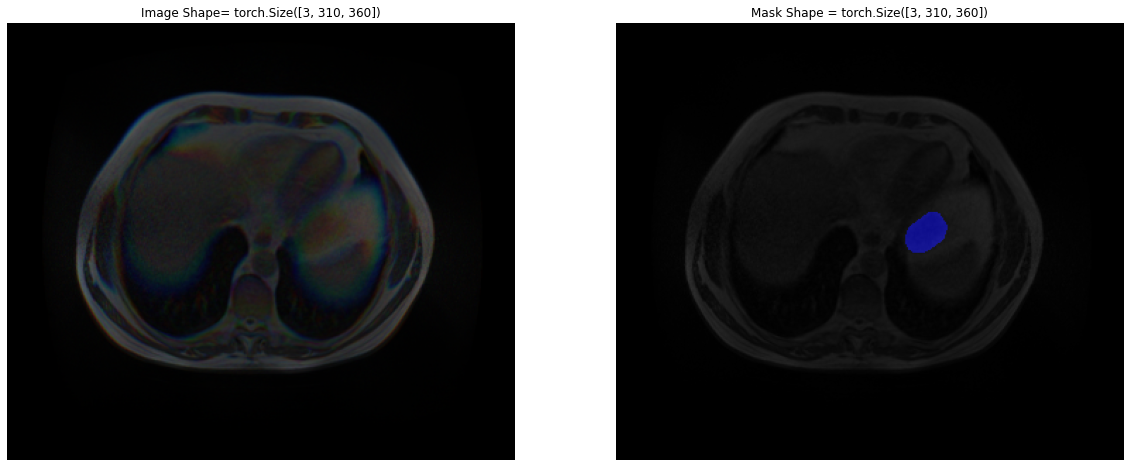

In [19]:
plot_data(dataset[19024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


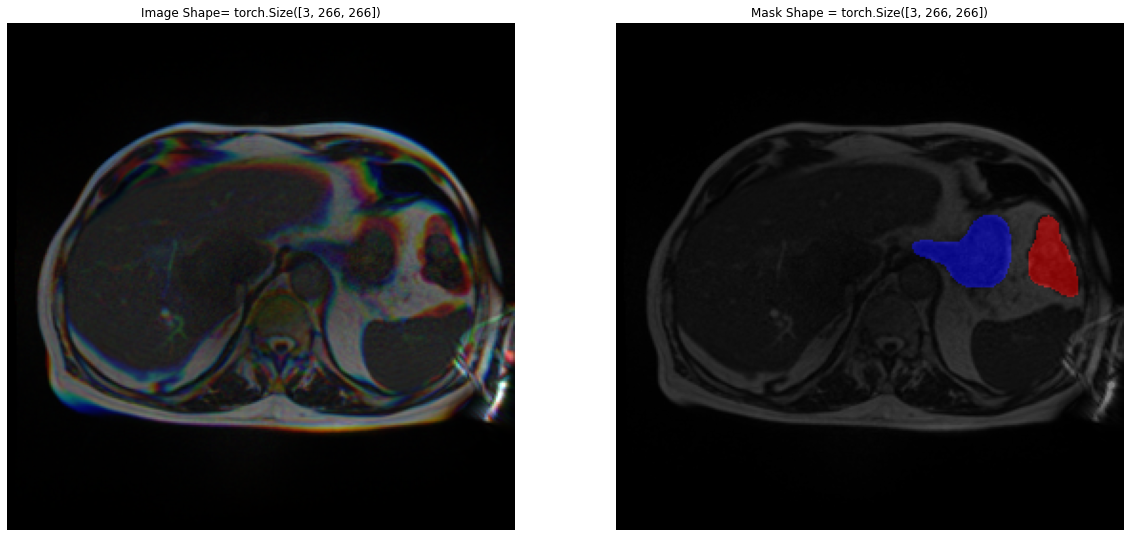

In [20]:
plot_data(dataset[360])

In [21]:
dataload= torch.utils.data.DataLoader(dataset=dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=False)

In [22]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')        
        

In [23]:
### Write transform that takes a 32 bit image and turns into a float 0-1 bit image.

In [24]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

train_transforms = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.00, scale_limit=0.04, rotate_limit=5, border_mode=0,p=0.75),
    
    A.OneOf([
            A.GridDistortion(num_steps=10, distort_limit=0.2, border_mode=0, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=100, sigma=20, alpha_affine=0, border_mode=0,p=1.0)
        ], p=0.5),
        A.CoarseDropout(max_holes=8, max_height=256//20, max_width=256//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0)
    

scale_transforms = transforms.Compose(
    [transforms.Normalize(0,1),
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet


In [25]:
scale_transforms = transforms.Compose(
    [squarepad_transform,
    #transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

In [26]:
dataset = Dataset_2_5_from_df(df25d[df25d['segmentations']],TRAIN_FOLDER, joint_transform=train_transforms,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)

In [27]:
dataset[665]['image'].max()

tensor(0.4386)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


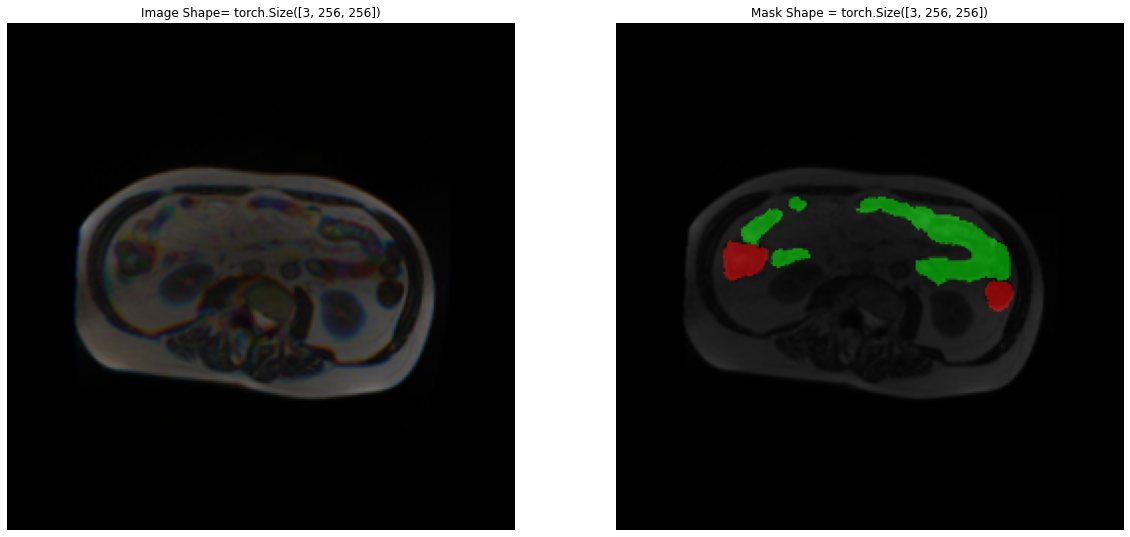

In [28]:
plot_data(dataset[667])

In [29]:
df2d.iloc[667]

large_bowel        32539 8 32897 11 33256 13 33615 15 33974 17 34...
small_bowel        34726 6 35085 8 35444 10 35803 11 36162 12 365...
stomach            33007 9 33364 14 33723 17 34082 19 34441 21 34...
id                                           case102_day0_slice_0092
case_id_str                                                  case102
case_id                                                          102
day_num_str                                                     day0
day_num                                                            0
slice_id                                                  slice_0092
slice_num                                                         92
match                          case102/case102_day0/scans/slice_0092
subpath            case102/case102_day0/scans/slice_0092_360_310_...
filename                            slice_0092_360_310_1.50_1.50.png
im_height                                                        360
im_width                          

### With n fold cross validation we need a dataset for each fold

In [30]:
def prepare_datasets(df, fold, train_transforms, scale_transforms):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)

    train_dataset = Dataset_2_5_from_df(train_df,TRAIN_FOLDER, joint_transform=train_transforms,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    valid_dataset = Dataset_2_5_from_df(valid_df,TRAIN_FOLDER, joint_transform=None,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    
    return train_dataset, valid_dataset

# Training

In [31]:
import segmentation_models_pytorch as smp


## Loss Functions and Metrics

In [32]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel',from_logits=True)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*DiceLoss(y_pred, y_true)

## Training Loops

In [33]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):


    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        #print(images.shape, masks.shape)
        
        output = model(images)

        loss = loss_fn(output, masks)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)

        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [34]:
def validatefp32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        
        with torch.no_grad():
            output = model(images)
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

## Training

In [35]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')        
        


In [36]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

train_transforms = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.00, scale_limit=0.04, rotate_limit=5, border_mode=0,p=0.75),
    
    A.OneOf([
            A.GridDistortion(num_steps=10, distort_limit=0.2, border_mode=0, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=100, sigma=20, alpha_affine=0, border_mode=0,p=1.0)
        ], p=0.5),
        A.CoarseDropout(max_holes=8, max_height=256//20, max_width=256//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0)
    

scale_transforms = transforms.Compose(
    [squarepad_transform,
    #transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

### Training

In [ ]:
init_lr = .001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [ ]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="densenet121",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()


    
    train_dataset, valid_dataset = prepare_datasets(df25d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=16,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=16,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999
    
    
    for epoch in range(1, epochs + 1):

        #lr = lr_scheduler.get_last_lr()
        lr = optimizer.param_groups[0]['lr']
        #print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

In [ ]:
:::::::

### More training

In [37]:
init_lr = .0005
epochs = 100
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [38]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="densenet121",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()


    #Load files from past training to improve apon them
    model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    model.load_state_dict(torch.load(model_in_str))
    
    train_dataset, valid_dataset = prepare_datasets(df25d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=16,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=16,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999

    for epoch in range(1, epochs + 1):

        lr = lr_scheduler.get_last_lr()
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 2.000e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0579, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1184, Metric = 0.898
Fold: 0, Epoch: 2, LR: 2.131e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0579, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1188, Metric = 0.897
Fold: 0, Epoch: 3, LR: 2.524e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0575, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1185, Metric = 0.898
Fold: 0, Epoch: 4, LR: 3.175e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1191, Metric = 0.898
Fold: 0, Epoch: 5, LR: 4.075e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0571, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1174, Metric = 0.897
Fold: 0, Epoch: 6, LR: 5.216e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0568, Metric: 0.957,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1178, Metric = 0.894
Fold: 0, Epoch: 7, LR: 6.584e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0568, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.896
Fold: 0, Epoch: 8, LR: 8.165e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0572, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1204, Metric = 0.891
Fold: 0, Epoch: 9, LR: 9.941e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0565, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1166, Metric = 0.897
Fold: 0, Epoch: 10, LR: 1.189e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0570, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1366, Metric = 0.883
Fold: 0, Epoch: 11, LR: 1.400e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0569, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.892
Fold: 0, Epoch: 12, LR: 1.624e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0574, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1194, Metric = 0.898
Fold: 0, Epoch: 13, LR: 1.858e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0572, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1252, Metric = 0.892
Fold: 0, Epoch: 14, LR: 2.101e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0579, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1233, Metric = 0.897
Fold: 0, Epoch: 15, LR: 2.349e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0573, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1232, Metric = 0.899
Fold: 0, Epoch: 16, LR: 2.600e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0592, Metric: 0.953,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1341, Metric = 0.880
Fold: 0, Epoch: 17, LR: 2.851e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0588, Metric: 0.953,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1186, Metric = 0.898
Fold: 0, Epoch: 18, LR: 3.099e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0596, Metric: 0.952,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1247, Metric = 0.896
Fold: 0, Epoch: 19, LR: 3.342e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0595, Metric: 0.952,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1237, Metric = 0.894
Fold: 0, Epoch: 20, LR: 3.576e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0610, Metric: 0.950,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1188, Metric = 0.897
Fold: 0, Epoch: 21, LR: 3.800e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0618, Metric: 0.949,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.895
Fold: 0, Epoch: 22, LR: 4.011e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0606, Metric: 0.951,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1182, Metric = 0.896
Fold: 0, Epoch: 23, LR: 4.206e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0607, Metric: 0.951,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1229, Metric = 0.894
Fold: 0, Epoch: 24, LR: 4.384e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0627, Metric: 0.949,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1173, Metric = 0.898
Fold: 0, Epoch: 25, LR: 4.542e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0611, Metric: 0.950,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1200, Metric = 0.894
Fold: 0, Epoch: 26, LR: 4.679e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0608, Metric: 0.950,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1296, Metric = 0.891
Fold: 0, Epoch: 27, LR: 4.793e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0607, Metric: 0.950,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1227, Metric = 0.895
Fold: 0, Epoch: 28, LR: 4.883e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0616, Metric: 0.950,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1182, Metric = 0.896
Fold: 0, Epoch: 29, LR: 4.948e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0622, Metric: 0.949,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1318, Metric = 0.892
Fold: 0, Epoch: 30, LR: 4.987e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0597, Metric: 0.951,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1208, Metric = 0.895
Fold: 0, Epoch: 31, LR: 5.000e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0618, Metric: 0.949,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1200, Metric = 0.890
Fold: 0, Epoch: 32, LR: 4.997e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0600, Metric: 0.951,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1207, Metric = 0.895
Fold: 0, Epoch: 33, LR: 4.990e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0600, Metric: 0.952,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1256, Metric = 0.890
Fold: 0, Epoch: 34, LR: 4.977e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0617, Metric: 0.949,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.899
Fold: 0, Epoch: 35, LR: 4.960e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0586, Metric: 0.953,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1222, Metric = 0.894
Fold: 0, Epoch: 36, LR: 4.937e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0589, Metric: 0.952,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1191, Metric = 0.897
Fold: 0, Epoch: 37, LR: 4.910e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0576, Metric: 0.954,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.897
Fold: 0, Epoch: 38, LR: 4.878e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.953,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1184, Metric = 0.899
Fold: 0, Epoch: 39, LR: 4.841e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0566, Metric: 0.954,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1173, Metric = 0.897
Fold: 0, Epoch: 40, LR: 4.799e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0573, Metric: 0.954,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1241, Metric = 0.893
Fold: 0, Epoch: 41, LR: 4.752e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0560, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1184, Metric = 0.897
Fold: 0, Epoch: 42, LR: 4.701e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0545, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1211, Metric = 0.897
Fold: 0, Epoch: 43, LR: 4.646e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0548, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1227, Metric = 0.894
Fold: 0, Epoch: 44, LR: 4.586e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0556, Metric: 0.955,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1176, Metric = 0.895
Fold: 0, Epoch: 45, LR: 4.523e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0548, Metric: 0.957,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1171, Metric = 0.896
Fold: 0, Epoch: 46, LR: 4.455e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0564, Metric: 0.954,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1226, Metric = 0.893
Fold: 0, Epoch: 47, LR: 4.383e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0560, Metric: 0.954,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1264, Metric = 0.893
Fold: 0, Epoch: 48, LR: 4.307e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0541, Metric: 0.957,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.896
Fold: 0, Epoch: 49, LR: 4.228e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0543, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.891
Fold: 0, Epoch: 50, LR: 4.145e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0545, Metric: 0.956,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1151, Metric = 0.898
Fold: 0, Epoch: 51, LR: 4.059e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.959,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1167, Metric = 0.897
Fold: 0, Epoch: 52, LR: 3.969e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0511, Metric: 0.960,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1184, Metric = 0.894
Fold: 0, Epoch: 53, LR: 3.877e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0516, Metric: 0.960,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1179, Metric = 0.893
Fold: 0, Epoch: 54, LR: 3.782e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.960,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1244, Metric = 0.893
Fold: 0, Epoch: 55, LR: 3.685e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0502, Metric: 0.961,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1170, Metric = 0.899
Fold: 0, Epoch: 56, LR: 3.585e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.960,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.898
Fold: 0, Epoch: 57, LR: 3.483e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0500, Metric: 0.962,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1203, Metric = 0.891
Fold: 0, Epoch: 58, LR: 3.378e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0500, Metric: 0.961,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1185, Metric = 0.900
Fold: 0, Epoch: 59, LR: 3.272e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0498, Metric: 0.962,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1221, Metric = 0.896
Fold: 0, Epoch: 60, LR: 3.165e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0484, Metric: 0.962,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1189, Metric = 0.897
Fold: 0, Epoch: 61, LR: 3.056e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0486, Metric: 0.963,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1162, Metric = 0.898
Fold: 0, Epoch: 62, LR: 2.946e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0485, Metric: 0.963,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1145, Metric = 0.899
Fold: 0, Epoch: 63, LR: 2.836e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0476, Metric: 0.963,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1185, Metric = 0.899
Fold: 0, Epoch: 64, LR: 2.724e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0473, Metric: 0.964,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1203, Metric = 0.892
Fold: 0, Epoch: 65, LR: 2.612e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0466, Metric: 0.965,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1229, Metric = 0.890
Fold: 0, Epoch: 66, LR: 2.500e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0466, Metric: 0.964,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.897
Fold: 0, Epoch: 67, LR: 2.388e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0458, Metric: 0.966,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1193, Metric = 0.897
Fold: 0, Epoch: 68, LR: 2.276e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0459, Metric: 0.966,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.898
Fold: 0, Epoch: 69, LR: 2.164e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0449, Metric: 0.966,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1173, Metric = 0.898
Fold: 0, Epoch: 70, LR: 2.054e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0448, Metric: 0.967,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1166, Metric = 0.898
Fold: 0, Epoch: 71, LR: 1.944e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.967,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1184, Metric = 0.897
Fold: 0, Epoch: 72, LR: 1.835e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0438, Metric: 0.968,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1159, Metric = 0.898
Fold: 0, Epoch: 73, LR: 1.727e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0434, Metric: 0.968,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1193, Metric = 0.898
Fold: 0, Epoch: 74, LR: 1.622e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0427, Metric: 0.969,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.899
Fold: 0, Epoch: 75, LR: 1.517e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0425, Metric: 0.969,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.897
Fold: 0, Epoch: 76, LR: 1.415e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0431, Metric: 0.969,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1179, Metric = 0.897
Fold: 0, Epoch: 77, LR: 1.315e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0417, Metric: 0.970,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1179, Metric = 0.898
Fold: 0, Epoch: 78, LR: 1.218e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0415, Metric: 0.970,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1167, Metric = 0.900
Fold: 0, Epoch: 79, LR: 1.123e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0418, Metric: 0.970,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.899
Fold: 0, Epoch: 80, LR: 1.031e-04--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0415, Metric: 0.970,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.899
Fold: 0, Epoch: 81, LR: 9.412e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0410, Metric: 0.971,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1216, Metric = 0.896
Fold: 0, Epoch: 82, LR: 8.551e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0405, Metric: 0.971,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1183, Metric = 0.899
Fold: 0, Epoch: 83, LR: 7.723e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0404, Metric: 0.971,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1155, Metric = 0.899
Fold: 0, Epoch: 84, LR: 6.930e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0400, Metric: 0.972,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1177, Metric = 0.897
Fold: 0, Epoch: 85, LR: 6.173e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0399, Metric: 0.972,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1170, Metric = 0.900
Fold: 0, Epoch: 86, LR: 5.454e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0394, Metric: 0.972,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1159, Metric = 0.899
Fold: 0, Epoch: 87, LR: 4.774e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0396, Metric: 0.972,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.899
Fold: 0, Epoch: 88, LR: 4.136e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0389, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.899
Fold: 0, Epoch: 89, LR: 3.539e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0396, Metric: 0.972,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1187, Metric = 0.900
Fold: 0, Epoch: 90, LR: 2.985e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0387, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1163, Metric = 0.900
Fold: 0, Epoch: 91, LR: 2.476e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0391, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1158, Metric = 0.898
Fold: 0, Epoch: 92, LR: 2.012e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0391, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1150, Metric = 0.900
Fold: 0, Epoch: 93, LR: 1.594e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0393, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1183, Metric = 0.899
Fold: 0, Epoch: 94, LR: 1.224e-05--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1172, Metric = 0.900
Fold: 0, Epoch: 95, LR: 9.010e-06--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0386, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1159, Metric = 0.900
Fold: 0, Epoch: 96, LR: 6.269e-06--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0385, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1174, Metric = 0.899
Fold: 0, Epoch: 97, LR: 4.019e-06--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1164, Metric = 0.900
Fold: 0, Epoch: 98, LR: 2.264e-06--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1167, Metric = 0.900
Fold: 0, Epoch: 99, LR: 1.008e-06--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1151, Metric = 0.900
Fold: 0, Epoch: 100, LR: 2.535e-07--

  0%|          | 0/1852 [00:00<?, ?it/s]

Training-- Loss: 0.0385, Metric: 0.973,

  0%|          | 0/554 [00:00<?, ?it/s]

Validation-- Loss: 0.1164, Metric = 0.900
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-6-2.pth
Fold: 1, Epoch: 1, LR: 2.000e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0581, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1155, Metric = 0.889
Fold: 1, Epoch: 2, LR: 2.131e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0588, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.888
Fold: 1, Epoch: 3, LR: 2.524e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0580, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1165, Metric = 0.887
Fold: 1, Epoch: 4, LR: 3.175e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0572, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1162, Metric = 0.889
Fold: 1, Epoch: 5, LR: 4.075e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0573, Metric: 0.956,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1172, Metric = 0.885
Fold: 1, Epoch: 6, LR: 5.216e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0575, Metric: 0.956,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1172, Metric = 0.888
Fold: 1, Epoch: 7, LR: 6.584e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0581, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1162, Metric = 0.887
Fold: 1, Epoch: 8, LR: 8.165e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0570, Metric: 0.956,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1193, Metric = 0.885
Fold: 1, Epoch: 9, LR: 9.941e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0580, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1155, Metric = 0.884
Fold: 1, Epoch: 10, LR: 1.189e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1194, Metric = 0.882
Fold: 1, Epoch: 11, LR: 1.400e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.954,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1165, Metric = 0.881
Fold: 1, Epoch: 12, LR: 1.624e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1246, Metric = 0.868
Fold: 1, Epoch: 13, LR: 1.858e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0589, Metric: 0.954,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1218, Metric = 0.882
Fold: 1, Epoch: 14, LR: 2.101e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0583, Metric: 0.954,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1242, Metric = 0.880
Fold: 1, Epoch: 15, LR: 2.349e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0583, Metric: 0.953,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1206, Metric = 0.891
Fold: 1, Epoch: 16, LR: 2.600e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0609, Metric: 0.952,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1179, Metric = 0.883
Fold: 1, Epoch: 17, LR: 2.851e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.953,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1198, Metric = 0.884
Fold: 1, Epoch: 18, LR: 3.099e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0608, Metric: 0.952,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1203, Metric = 0.885
Fold: 1, Epoch: 19, LR: 3.342e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0601, Metric: 0.952,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1217, Metric = 0.882
Fold: 1, Epoch: 20, LR: 3.576e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0607, Metric: 0.951,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1286, Metric = 0.864
Fold: 1, Epoch: 21, LR: 3.800e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0615, Metric: 0.950,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.871
Fold: 1, Epoch: 22, LR: 4.011e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0617, Metric: 0.949,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1235, Metric = 0.875
Fold: 1, Epoch: 23, LR: 4.206e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0606, Metric: 0.951,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1268, Metric = 0.870
Fold: 1, Epoch: 24, LR: 4.384e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.950,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.874
Fold: 1, Epoch: 25, LR: 4.542e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0633, Metric: 0.948,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1369, Metric = 0.849
Fold: 1, Epoch: 26, LR: 4.679e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0612, Metric: 0.950,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1337, Metric = 0.874
Fold: 1, Epoch: 27, LR: 4.793e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0617, Metric: 0.950,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1241, Metric = 0.872
Fold: 1, Epoch: 28, LR: 4.883e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0622, Metric: 0.949,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1276, Metric = 0.888
Fold: 1, Epoch: 29, LR: 4.948e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0610, Metric: 0.951,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1200, Metric = 0.886
Fold: 1, Epoch: 30, LR: 4.987e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0630, Metric: 0.948,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1262, Metric = 0.872
Fold: 1, Epoch: 31, LR: 5.000e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.950,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1203, Metric = 0.886
Fold: 1, Epoch: 32, LR: 4.997e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0610, Metric: 0.950,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1212, Metric = 0.891
Fold: 1, Epoch: 33, LR: 4.990e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.951,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1259, Metric = 0.879
Fold: 1, Epoch: 34, LR: 4.977e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0595, Metric: 0.952,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1204, Metric = 0.883
Fold: 1, Epoch: 35, LR: 4.960e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0596, Metric: 0.952,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.887
Fold: 1, Epoch: 36, LR: 4.937e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0590, Metric: 0.953,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1293, Metric = 0.880
Fold: 1, Epoch: 37, LR: 4.910e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0594, Metric: 0.951,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.891
Fold: 1, Epoch: 38, LR: 4.878e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0601, Metric: 0.951,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1194, Metric = 0.886
Fold: 1, Epoch: 39, LR: 4.841e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0573, Metric: 0.954,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1247, Metric = 0.886
Fold: 1, Epoch: 40, LR: 4.799e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0583, Metric: 0.953,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1291, Metric = 0.881
Fold: 1, Epoch: 41, LR: 4.752e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0579, Metric: 0.952,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1187, Metric = 0.894
Fold: 1, Epoch: 42, LR: 4.701e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0566, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1208, Metric = 0.889
Fold: 1, Epoch: 43, LR: 4.646e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0557, Metric: 0.956,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1313, Metric = 0.876
Fold: 1, Epoch: 44, LR: 4.586e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0565, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1265, Metric = 0.875
Fold: 1, Epoch: 45, LR: 4.523e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0551, Metric: 0.956,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1311, Metric = 0.881
Fold: 1, Epoch: 46, LR: 4.455e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0554, Metric: 0.955,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1238, Metric = 0.884
Fold: 1, Epoch: 47, LR: 4.383e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0539, Metric: 0.957,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1206, Metric = 0.885
Fold: 1, Epoch: 48, LR: 4.307e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0546, Metric: 0.956,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1204, Metric = 0.881
Fold: 1, Epoch: 49, LR: 4.228e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0534, Metric: 0.957,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1220, Metric = 0.881
Fold: 1, Epoch: 50, LR: 4.145e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0530, Metric: 0.958,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1301, Metric = 0.871
Fold: 1, Epoch: 51, LR: 4.059e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0529, Metric: 0.958,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1254, Metric = 0.884
Fold: 1, Epoch: 52, LR: 3.969e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.959,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1234, Metric = 0.880
Fold: 1, Epoch: 53, LR: 3.877e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.961,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1186, Metric = 0.889
Fold: 1, Epoch: 54, LR: 3.782e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0519, Metric: 0.960,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1267, Metric = 0.874
Fold: 1, Epoch: 55, LR: 3.685e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0506, Metric: 0.961,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1190, Metric = 0.889
Fold: 1, Epoch: 56, LR: 3.585e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0496, Metric: 0.961,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.889
Fold: 1, Epoch: 57, LR: 3.483e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.961,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1229, Metric = 0.885
Fold: 1, Epoch: 58, LR: 3.378e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0509, Metric: 0.959,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1394, Metric = 0.879
Fold: 1, Epoch: 59, LR: 3.272e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0483, Metric: 0.962,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1234, Metric = 0.888
Fold: 1, Epoch: 60, LR: 3.165e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0481, Metric: 0.963,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1194, Metric = 0.888
Fold: 1, Epoch: 61, LR: 3.056e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0488, Metric: 0.962,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1258, Metric = 0.889
Fold: 1, Epoch: 62, LR: 2.946e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0474, Metric: 0.964,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1205, Metric = 0.890
Fold: 1, Epoch: 63, LR: 2.836e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0475, Metric: 0.965,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1266, Metric = 0.888
Fold: 1, Epoch: 64, LR: 2.724e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0468, Metric: 0.965,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1251, Metric = 0.884
Fold: 1, Epoch: 65, LR: 2.612e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0467, Metric: 0.965,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1272, Metric = 0.881
Fold: 1, Epoch: 66, LR: 2.500e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0464, Metric: 0.965,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1214, Metric = 0.893
Fold: 1, Epoch: 67, LR: 2.388e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0452, Metric: 0.967,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1229, Metric = 0.891
Fold: 1, Epoch: 68, LR: 2.276e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0458, Metric: 0.965,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1263, Metric = 0.888
Fold: 1, Epoch: 69, LR: 2.164e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0451, Metric: 0.967,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.888
Fold: 1, Epoch: 70, LR: 2.054e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0437, Metric: 0.968,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1211, Metric = 0.893
Fold: 1, Epoch: 71, LR: 1.944e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.967,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1242, Metric = 0.884
Fold: 1, Epoch: 72, LR: 1.835e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0437, Metric: 0.968,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1220, Metric = 0.886
Fold: 1, Epoch: 73, LR: 1.727e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0439, Metric: 0.968,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.885
Fold: 1, Epoch: 74, LR: 1.622e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0431, Metric: 0.968,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1237, Metric = 0.886
Fold: 1, Epoch: 75, LR: 1.517e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0435, Metric: 0.968,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1274, Metric = 0.883
Fold: 1, Epoch: 76, LR: 1.415e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0430, Metric: 0.969,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1212, Metric = 0.885
Fold: 1, Epoch: 77, LR: 1.315e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0418, Metric: 0.970,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1251, Metric = 0.886
Fold: 1, Epoch: 78, LR: 1.218e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0419, Metric: 0.970,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1197, Metric = 0.891
Fold: 1, Epoch: 79, LR: 1.123e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0414, Metric: 0.970,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1215, Metric = 0.887
Fold: 1, Epoch: 80, LR: 1.031e-04--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0409, Metric: 0.971,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1211, Metric = 0.886
Fold: 1, Epoch: 81, LR: 9.412e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0405, Metric: 0.971,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1205, Metric = 0.891
Fold: 1, Epoch: 82, LR: 8.551e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0407, Metric: 0.971,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1212, Metric = 0.892
Fold: 1, Epoch: 83, LR: 7.723e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0397, Metric: 0.972,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1200, Metric = 0.894
Fold: 1, Epoch: 84, LR: 6.930e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0400, Metric: 0.972,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1214, Metric = 0.892
Fold: 1, Epoch: 85, LR: 6.173e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0397, Metric: 0.972,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1202, Metric = 0.891
Fold: 1, Epoch: 86, LR: 5.454e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0393, Metric: 0.972,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1215, Metric = 0.891
Fold: 1, Epoch: 87, LR: 4.774e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0393, Metric: 0.972,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1215, Metric = 0.892
Fold: 1, Epoch: 88, LR: 4.136e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0393, Metric: 0.972,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1207, Metric = 0.890
Fold: 1, Epoch: 89, LR: 3.539e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0391, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1184, Metric = 0.892
Fold: 1, Epoch: 90, LR: 2.985e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0390, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1202, Metric = 0.891
Fold: 1, Epoch: 91, LR: 2.476e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0385, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.892
Fold: 1, Epoch: 92, LR: 2.012e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0386, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.892
Fold: 1, Epoch: 93, LR: 1.594e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0386, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.890
Fold: 1, Epoch: 94, LR: 1.224e-05--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0383, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1205, Metric = 0.891
Fold: 1, Epoch: 95, LR: 9.010e-06--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0385, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1191, Metric = 0.892
Fold: 1, Epoch: 96, LR: 6.269e-06--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1218, Metric = 0.892
Fold: 1, Epoch: 97, LR: 4.019e-06--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0383, Metric: 0.974,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1218, Metric = 0.890
Fold: 1, Epoch: 98, LR: 2.264e-06--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0383, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1218, Metric = 0.891
Fold: 1, Epoch: 99, LR: 1.008e-06--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0383, Metric: 0.973,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1221, Metric = 0.892
Fold: 1, Epoch: 100, LR: 2.535e-07--

  0%|          | 0/1850 [00:00<?, ?it/s]

Training-- Loss: 0.0382, Metric: 0.974,

  0%|          | 0/556 [00:00<?, ?it/s]

Validation-- Loss: 0.1189, Metric = 0.891
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-6-2.pth
Fold: 2, Epoch: 1, LR: 2.000e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0580, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1281, Metric = 0.896
Fold: 2, Epoch: 2, LR: 2.131e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0572, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1288, Metric = 0.895
Fold: 2, Epoch: 3, LR: 2.524e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0576, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1283, Metric = 0.895
Fold: 2, Epoch: 4, LR: 3.175e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0568, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1293, Metric = 0.893
Fold: 2, Epoch: 5, LR: 4.075e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0568, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1295, Metric = 0.892
Fold: 2, Epoch: 6, LR: 5.215e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0570, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1271, Metric = 0.894
Fold: 2, Epoch: 7, LR: 6.584e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0567, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1295, Metric = 0.892
Fold: 2, Epoch: 8, LR: 8.165e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0570, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1287, Metric = 0.892
Fold: 2, Epoch: 9, LR: 9.941e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0562, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1320, Metric = 0.888
Fold: 2, Epoch: 10, LR: 1.189e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0563, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1321, Metric = 0.890
Fold: 2, Epoch: 11, LR: 1.400e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0571, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1304, Metric = 0.891
Fold: 2, Epoch: 12, LR: 1.624e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0563, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1374, Metric = 0.887
Fold: 2, Epoch: 13, LR: 1.858e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0569, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1326, Metric = 0.892
Fold: 2, Epoch: 14, LR: 2.101e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0574, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1343, Metric = 0.892
Fold: 2, Epoch: 15, LR: 2.349e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0577, Metric: 0.954,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1349, Metric = 0.892
Fold: 2, Epoch: 16, LR: 2.600e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0582, Metric: 0.954,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1344, Metric = 0.889
Fold: 2, Epoch: 17, LR: 2.851e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0587, Metric: 0.953,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1381, Metric = 0.883
Fold: 2, Epoch: 18, LR: 3.099e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0581, Metric: 0.953,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1321, Metric = 0.891
Fold: 2, Epoch: 19, LR: 3.342e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0586, Metric: 0.952,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1359, Metric = 0.884
Fold: 2, Epoch: 20, LR: 3.576e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0592, Metric: 0.952,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1397, Metric = 0.880
Fold: 2, Epoch: 21, LR: 3.800e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0593, Metric: 0.952,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1418, Metric = 0.881
Fold: 2, Epoch: 22, LR: 4.011e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0604, Metric: 0.950,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1356, Metric = 0.885
Fold: 2, Epoch: 23, LR: 4.206e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.950,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1392, Metric = 0.883
Fold: 2, Epoch: 24, LR: 4.384e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0622, Metric: 0.949,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1393, Metric = 0.882
Fold: 2, Epoch: 25, LR: 4.542e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0606, Metric: 0.949,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1375, Metric = 0.886
Fold: 2, Epoch: 26, LR: 4.679e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.950,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1391, Metric = 0.877
Fold: 2, Epoch: 27, LR: 4.793e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0607, Metric: 0.950,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1396, Metric = 0.883
Fold: 2, Epoch: 28, LR: 4.883e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0610, Metric: 0.949,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1400, Metric = 0.884
Fold: 2, Epoch: 29, LR: 4.948e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0606, Metric: 0.949,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1409, Metric = 0.881
Fold: 2, Epoch: 30, LR: 4.987e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.951,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1411, Metric = 0.876
Fold: 2, Epoch: 31, LR: 5.000e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0609, Metric: 0.950,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1429, Metric = 0.879
Fold: 2, Epoch: 32, LR: 4.997e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0616, Metric: 0.949,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1351, Metric = 0.882
Fold: 2, Epoch: 33, LR: 4.990e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.950,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1553, Metric = 0.880
Fold: 2, Epoch: 34, LR: 4.977e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0597, Metric: 0.951,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1488, Metric = 0.865
Fold: 2, Epoch: 35, LR: 4.960e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0587, Metric: 0.951,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1415, Metric = 0.879
Fold: 2, Epoch: 36, LR: 4.937e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.951,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1401, Metric = 0.877
Fold: 2, Epoch: 37, LR: 4.910e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0579, Metric: 0.953,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1383, Metric = 0.885
Fold: 2, Epoch: 38, LR: 4.878e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0575, Metric: 0.952,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1422, Metric = 0.882
Fold: 2, Epoch: 39, LR: 4.841e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0586, Metric: 0.952,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1464, Metric = 0.878
Fold: 2, Epoch: 40, LR: 4.799e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0566, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1394, Metric = 0.883
Fold: 2, Epoch: 41, LR: 4.752e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0561, Metric: 0.954,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1402, Metric = 0.879
Fold: 2, Epoch: 42, LR: 4.701e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0591, Metric: 0.952,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1415, Metric = 0.878
Fold: 2, Epoch: 43, LR: 4.646e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0557, Metric: 0.954,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1346, Metric = 0.886
Fold: 2, Epoch: 44, LR: 4.586e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0562, Metric: 0.955,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1370, Metric = 0.888
Fold: 2, Epoch: 45, LR: 4.523e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0545, Metric: 0.957,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1393, Metric = 0.884
Fold: 2, Epoch: 46, LR: 4.455e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0551, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1444, Metric = 0.880
Fold: 2, Epoch: 47, LR: 4.383e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0545, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1455, Metric = 0.881
Fold: 2, Epoch: 48, LR: 4.307e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0549, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1425, Metric = 0.882
Fold: 2, Epoch: 49, LR: 4.228e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0541, Metric: 0.957,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1420, Metric = 0.886
Fold: 2, Epoch: 50, LR: 4.145e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0525, Metric: 0.958,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1395, Metric = 0.882
Fold: 2, Epoch: 51, LR: 4.059e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0524, Metric: 0.958,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1461, Metric = 0.878
Fold: 2, Epoch: 52, LR: 3.969e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.959,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1525, Metric = 0.878
Fold: 2, Epoch: 53, LR: 3.877e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0541, Metric: 0.956,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1354, Metric = 0.887
Fold: 2, Epoch: 54, LR: 3.782e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0498, Metric: 0.961,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1407, Metric = 0.884
Fold: 2, Epoch: 55, LR: 3.685e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0512, Metric: 0.959,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1400, Metric = 0.885
Fold: 2, Epoch: 56, LR: 3.585e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0496, Metric: 0.961,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1474, Metric = 0.881
Fold: 2, Epoch: 57, LR: 3.483e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.960,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1437, Metric = 0.880
Fold: 2, Epoch: 58, LR: 3.378e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0495, Metric: 0.961,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1386, Metric = 0.882
Fold: 2, Epoch: 59, LR: 3.272e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0486, Metric: 0.963,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1401, Metric = 0.884
Fold: 2, Epoch: 60, LR: 3.165e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0488, Metric: 0.963,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1398, Metric = 0.884
Fold: 2, Epoch: 61, LR: 3.056e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0479, Metric: 0.963,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1390, Metric = 0.885
Fold: 2, Epoch: 62, LR: 2.946e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0483, Metric: 0.963,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1431, Metric = 0.885
Fold: 2, Epoch: 63, LR: 2.836e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0485, Metric: 0.961,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1362, Metric = 0.885
Fold: 2, Epoch: 64, LR: 2.724e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0472, Metric: 0.964,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1412, Metric = 0.883
Fold: 2, Epoch: 65, LR: 2.612e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0467, Metric: 0.964,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1388, Metric = 0.885
Fold: 2, Epoch: 66, LR: 2.500e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0456, Metric: 0.965,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1395, Metric = 0.886
Fold: 2, Epoch: 67, LR: 2.388e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.965,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1381, Metric = 0.885
Fold: 2, Epoch: 68, LR: 2.276e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.966,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1409, Metric = 0.882
Fold: 2, Epoch: 69, LR: 2.164e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0443, Metric: 0.967,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1439, Metric = 0.880
Fold: 2, Epoch: 70, LR: 2.054e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0445, Metric: 0.966,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1409, Metric = 0.883
Fold: 2, Epoch: 71, LR: 1.944e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0437, Metric: 0.967,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1365, Metric = 0.884
Fold: 2, Epoch: 72, LR: 1.835e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0436, Metric: 0.967,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1376, Metric = 0.886
Fold: 2, Epoch: 73, LR: 1.727e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0432, Metric: 0.968,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1385, Metric = 0.885
Fold: 2, Epoch: 74, LR: 1.622e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0434, Metric: 0.968,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1380, Metric = 0.890
Fold: 2, Epoch: 75, LR: 1.517e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0422, Metric: 0.969,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1394, Metric = 0.886
Fold: 2, Epoch: 76, LR: 1.415e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0424, Metric: 0.969,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1379, Metric = 0.887
Fold: 2, Epoch: 77, LR: 1.315e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0417, Metric: 0.970,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1395, Metric = 0.886
Fold: 2, Epoch: 78, LR: 1.218e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0410, Metric: 0.970,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1343, Metric = 0.886
Fold: 2, Epoch: 79, LR: 1.123e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0412, Metric: 0.971,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1352, Metric = 0.886
Fold: 2, Epoch: 80, LR: 1.031e-04--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0407, Metric: 0.971,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1375, Metric = 0.889
Fold: 2, Epoch: 81, LR: 9.412e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0403, Metric: 0.971,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1357, Metric = 0.889
Fold: 2, Epoch: 82, LR: 8.551e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0402, Metric: 0.971,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1337, Metric = 0.888
Fold: 2, Epoch: 83, LR: 7.723e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0397, Metric: 0.972,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1361, Metric = 0.889
Fold: 2, Epoch: 84, LR: 6.930e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0397, Metric: 0.972,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1358, Metric = 0.889
Fold: 2, Epoch: 85, LR: 6.173e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0396, Metric: 0.972,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1349, Metric = 0.889
Fold: 2, Epoch: 86, LR: 5.454e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0395, Metric: 0.972,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1352, Metric = 0.889
Fold: 2, Epoch: 87, LR: 4.774e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0392, Metric: 0.972,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1388, Metric = 0.889
Fold: 2, Epoch: 88, LR: 4.136e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0390, Metric: 0.972,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1364, Metric = 0.889
Fold: 2, Epoch: 89, LR: 3.539e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1380, Metric = 0.889
Fold: 2, Epoch: 90, LR: 2.985e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0385, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1400, Metric = 0.889
Fold: 2, Epoch: 91, LR: 2.476e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0385, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1354, Metric = 0.889
Fold: 2, Epoch: 92, LR: 2.012e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0381, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1352, Metric = 0.889
Fold: 2, Epoch: 93, LR: 1.594e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0385, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1392, Metric = 0.889
Fold: 2, Epoch: 94, LR: 1.224e-05--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0382, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1394, Metric = 0.889
Fold: 2, Epoch: 95, LR: 9.010e-06--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0383, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1361, Metric = 0.888
Fold: 2, Epoch: 96, LR: 6.269e-06--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0382, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1371, Metric = 0.890
Fold: 2, Epoch: 97, LR: 4.019e-06--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0381, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1361, Metric = 0.888
Fold: 2, Epoch: 98, LR: 2.264e-06--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0383, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1347, Metric = 0.889
Fold: 2, Epoch: 99, LR: 1.008e-06--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0378, Metric: 0.973,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1378, Metric = 0.889
Fold: 2, Epoch: 100, LR: 2.535e-07--

  0%|          | 0/2001 [00:00<?, ?it/s]

Training-- Loss: 0.0386, Metric: 0.974,

  0%|          | 0/405 [00:00<?, ?it/s]

Validation-- Loss: 0.1373, Metric = 0.888
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-6-2.pth
Fold: 3, Epoch: 1, LR: 2.000e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0608, Metric: 0.952,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0914, Metric = 0.920
Fold: 3, Epoch: 2, LR: 2.131e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0914, Metric = 0.923
Fold: 3, Epoch: 3, LR: 2.524e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0602, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0924, Metric = 0.921
Fold: 3, Epoch: 4, LR: 3.175e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0599, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0910, Metric = 0.920
Fold: 3, Epoch: 5, LR: 4.075e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0599, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0922, Metric = 0.921
Fold: 3, Epoch: 6, LR: 5.215e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0588, Metric: 0.954,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0901, Metric = 0.920
Fold: 3, Epoch: 7, LR: 6.584e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0594, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0930, Metric = 0.920
Fold: 3, Epoch: 8, LR: 8.165e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0595, Metric: 0.954,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0915, Metric = 0.921
Fold: 3, Epoch: 9, LR: 9.941e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0598, Metric: 0.952,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0965, Metric = 0.917
Fold: 3, Epoch: 10, LR: 1.189e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0965, Metric = 0.918
Fold: 3, Epoch: 11, LR: 1.400e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0597, Metric: 0.952,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0909, Metric = 0.918
Fold: 3, Epoch: 12, LR: 1.624e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0595, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0923, Metric = 0.918
Fold: 3, Epoch: 13, LR: 1.858e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0592, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0953, Metric = 0.918
Fold: 3, Epoch: 14, LR: 2.101e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0601, Metric: 0.952,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0931, Metric = 0.919
Fold: 3, Epoch: 15, LR: 2.349e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0606, Metric: 0.950,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0915, Metric = 0.920
Fold: 3, Epoch: 16, LR: 2.600e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0608, Metric: 0.950,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0940, Metric = 0.913
Fold: 3, Epoch: 17, LR: 2.851e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0610, Metric: 0.950,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0934, Metric = 0.916
Fold: 3, Epoch: 18, LR: 3.099e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0624, Metric: 0.949,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0964, Metric = 0.912
Fold: 3, Epoch: 19, LR: 3.342e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0625, Metric: 0.948,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0906, Metric = 0.917
Fold: 3, Epoch: 20, LR: 3.576e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0629, Metric: 0.947,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0943, Metric = 0.916
Fold: 3, Epoch: 21, LR: 3.800e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0620, Metric: 0.948,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0997, Metric = 0.919
Fold: 3, Epoch: 22, LR: 4.011e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0639, Metric: 0.947,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0957, Metric = 0.917
Fold: 3, Epoch: 23, LR: 4.206e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0626, Metric: 0.949,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0974, Metric = 0.920
Fold: 3, Epoch: 24, LR: 4.384e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0648, Metric: 0.946,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1003, Metric = 0.915
Fold: 3, Epoch: 25, LR: 4.542e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0621, Metric: 0.950,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1003, Metric = 0.913
Fold: 3, Epoch: 26, LR: 4.679e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0637, Metric: 0.946,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0987, Metric = 0.920
Fold: 3, Epoch: 27, LR: 4.793e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0627, Metric: 0.947,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0977, Metric = 0.916
Fold: 3, Epoch: 28, LR: 4.883e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0629, Metric: 0.947,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0955, Metric = 0.914
Fold: 3, Epoch: 29, LR: 4.948e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0623, Metric: 0.948,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0993, Metric = 0.914
Fold: 3, Epoch: 30, LR: 4.987e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0637, Metric: 0.946,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0954, Metric = 0.916
Fold: 3, Epoch: 31, LR: 5.000e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0614, Metric: 0.949,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0913, Metric = 0.915
Fold: 3, Epoch: 32, LR: 4.997e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0632, Metric: 0.947,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0951, Metric = 0.918
Fold: 3, Epoch: 33, LR: 4.990e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0634, Metric: 0.947,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0924, Metric = 0.921
Fold: 3, Epoch: 34, LR: 4.977e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.950,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0963, Metric = 0.920
Fold: 3, Epoch: 35, LR: 4.960e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0618, Metric: 0.947,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0958, Metric = 0.916
Fold: 3, Epoch: 36, LR: 4.937e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0597, Metric: 0.950,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0942, Metric = 0.916
Fold: 3, Epoch: 37, LR: 4.910e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0595, Metric: 0.951,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1000, Metric = 0.920
Fold: 3, Epoch: 38, LR: 4.878e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0614, Metric: 0.948,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0967, Metric = 0.920
Fold: 3, Epoch: 39, LR: 4.841e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.952,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0966, Metric = 0.920
Fold: 3, Epoch: 40, LR: 4.799e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0596, Metric: 0.951,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0962, Metric = 0.917
Fold: 3, Epoch: 41, LR: 4.752e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.952,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0935, Metric = 0.922
Fold: 3, Epoch: 42, LR: 4.701e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0587, Metric: 0.951,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0955, Metric = 0.918
Fold: 3, Epoch: 43, LR: 4.646e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0574, Metric: 0.954,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0927, Metric = 0.918
Fold: 3, Epoch: 44, LR: 4.586e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0586, Metric: 0.951,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0905, Metric = 0.922
Fold: 3, Epoch: 45, LR: 4.523e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0600, Metric: 0.950,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0989, Metric = 0.918
Fold: 3, Epoch: 46, LR: 4.455e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0550, Metric: 0.955,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0929, Metric = 0.919
Fold: 3, Epoch: 47, LR: 4.383e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0567, Metric: 0.954,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1011, Metric = 0.916
Fold: 3, Epoch: 48, LR: 4.307e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0577, Metric: 0.953,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0967, Metric = 0.920
Fold: 3, Epoch: 49, LR: 4.228e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0549, Metric: 0.956,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1067, Metric = 0.900
Fold: 3, Epoch: 50, LR: 4.145e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0545, Metric: 0.956,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0920, Metric = 0.918
Fold: 3, Epoch: 51, LR: 4.059e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0550, Metric: 0.955,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0920, Metric = 0.920
Fold: 3, Epoch: 52, LR: 3.969e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0524, Metric: 0.958,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0931, Metric = 0.921
Fold: 3, Epoch: 53, LR: 3.877e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0540, Metric: 0.957,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.1014, Metric = 0.917
Fold: 3, Epoch: 54, LR: 3.782e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0534, Metric: 0.957,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0970, Metric = 0.920
Fold: 3, Epoch: 55, LR: 3.685e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0522, Metric: 0.958,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0985, Metric = 0.919
Fold: 3, Epoch: 56, LR: 3.585e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0519, Metric: 0.959,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0935, Metric = 0.919
Fold: 3, Epoch: 57, LR: 3.483e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0514, Metric: 0.960,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0925, Metric = 0.924
Fold: 3, Epoch: 58, LR: 3.378e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.960,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0930, Metric = 0.923
Fold: 3, Epoch: 59, LR: 3.272e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0499, Metric: 0.961,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0913, Metric = 0.924
Fold: 3, Epoch: 60, LR: 3.165e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0500, Metric: 0.961,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0907, Metric = 0.920
Fold: 3, Epoch: 61, LR: 3.056e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0504, Metric: 0.960,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0926, Metric = 0.922
Fold: 3, Epoch: 62, LR: 2.946e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0494, Metric: 0.962,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0930, Metric = 0.918
Fold: 3, Epoch: 63, LR: 2.836e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0485, Metric: 0.962,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0977, Metric = 0.919
Fold: 3, Epoch: 64, LR: 2.724e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0483, Metric: 0.962,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0930, Metric = 0.922
Fold: 3, Epoch: 65, LR: 2.612e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0471, Metric: 0.964,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0914, Metric = 0.923
Fold: 3, Epoch: 66, LR: 2.500e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0471, Metric: 0.964,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0975, Metric = 0.918
Fold: 3, Epoch: 67, LR: 2.388e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0473, Metric: 0.963,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0914, Metric = 0.920
Fold: 3, Epoch: 68, LR: 2.276e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0463, Metric: 0.965,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0913, Metric = 0.923
Fold: 3, Epoch: 69, LR: 2.164e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.964,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0924, Metric = 0.920
Fold: 3, Epoch: 70, LR: 2.054e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0455, Metric: 0.966,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0925, Metric = 0.917
Fold: 3, Epoch: 71, LR: 1.944e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.966,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0916, Metric = 0.920
Fold: 3, Epoch: 72, LR: 1.835e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.966,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0940, Metric = 0.921
Fold: 3, Epoch: 73, LR: 1.727e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0448, Metric: 0.966,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0932, Metric = 0.918
Fold: 3, Epoch: 74, LR: 1.622e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0442, Metric: 0.967,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0933, Metric = 0.922
Fold: 3, Epoch: 75, LR: 1.517e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0437, Metric: 0.967,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0954, Metric = 0.916
Fold: 3, Epoch: 76, LR: 1.415e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0433, Metric: 0.968,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0925, Metric = 0.919
Fold: 3, Epoch: 77, LR: 1.315e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0430, Metric: 0.968,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0956, Metric = 0.921
Fold: 3, Epoch: 78, LR: 1.218e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0424, Metric: 0.969,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0934, Metric = 0.921
Fold: 3, Epoch: 79, LR: 1.123e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0418, Metric: 0.969,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0942, Metric = 0.919
Fold: 3, Epoch: 80, LR: 1.031e-04--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0425, Metric: 0.969,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0921, Metric = 0.923
Fold: 3, Epoch: 81, LR: 9.412e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0415, Metric: 0.970,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0938, Metric = 0.921
Fold: 3, Epoch: 82, LR: 8.551e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0414, Metric: 0.970,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0902, Metric = 0.922
Fold: 3, Epoch: 83, LR: 7.723e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0414, Metric: 0.970,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0942, Metric = 0.920
Fold: 3, Epoch: 84, LR: 6.930e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0405, Metric: 0.970,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0931, Metric = 0.923
Fold: 3, Epoch: 85, LR: 6.173e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0406, Metric: 0.971,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0926, Metric = 0.920
Fold: 3, Epoch: 86, LR: 5.454e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0404, Metric: 0.971,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0923, Metric = 0.922
Fold: 3, Epoch: 87, LR: 4.774e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0399, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0925, Metric = 0.921
Fold: 3, Epoch: 88, LR: 4.136e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0400, Metric: 0.971,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0926, Metric = 0.921
Fold: 3, Epoch: 89, LR: 3.539e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0398, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0924, Metric = 0.920
Fold: 3, Epoch: 90, LR: 2.985e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0398, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0931, Metric = 0.922
Fold: 3, Epoch: 91, LR: 2.476e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0394, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0933, Metric = 0.922
Fold: 3, Epoch: 92, LR: 2.012e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0396, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0934, Metric = 0.922
Fold: 3, Epoch: 93, LR: 1.594e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0393, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0936, Metric = 0.921
Fold: 3, Epoch: 94, LR: 1.224e-05--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0392, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0932, Metric = 0.922
Fold: 3, Epoch: 95, LR: 9.010e-06--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0392, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0937, Metric = 0.922
Fold: 3, Epoch: 96, LR: 6.269e-06--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0392, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0955, Metric = 0.922
Fold: 3, Epoch: 97, LR: 4.019e-06--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0391, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0905, Metric = 0.922
Fold: 3, Epoch: 98, LR: 2.264e-06--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0389, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0929, Metric = 0.922
Fold: 3, Epoch: 99, LR: 1.008e-06--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0391, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0934, Metric = 0.921
Fold: 3, Epoch: 100, LR: 2.535e-07--

  0%|          | 0/1958 [00:00<?, ?it/s]

Training-- Loss: 0.0390, Metric: 0.972,

  0%|          | 0/448 [00:00<?, ?it/s]

Validation-- Loss: 0.0915, Metric = 0.921
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-6-2.pth
Fold: 4, Epoch: 1, LR: 2.000e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0590, Metric: 0.953,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1132, Metric = 0.910
Fold: 4, Epoch: 2, LR: 2.131e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1163, Metric = 0.910
Fold: 4, Epoch: 3, LR: 2.524e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0584, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1124, Metric = 0.910
Fold: 4, Epoch: 4, LR: 3.175e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0580, Metric: 0.955,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1147, Metric = 0.909
Fold: 4, Epoch: 5, LR: 4.075e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0577, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1134, Metric = 0.905
Fold: 4, Epoch: 6, LR: 5.215e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0572, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1147, Metric = 0.908
Fold: 4, Epoch: 7, LR: 6.584e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0572, Metric: 0.955,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1118, Metric = 0.909
Fold: 4, Epoch: 8, LR: 8.165e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0576, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1139, Metric = 0.907
Fold: 4, Epoch: 9, LR: 9.941e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0576, Metric: 0.955,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1155, Metric = 0.907
Fold: 4, Epoch: 10, LR: 1.189e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0576, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.904
Fold: 4, Epoch: 11, LR: 1.400e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0575, Metric: 0.955,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1149, Metric = 0.901
Fold: 4, Epoch: 12, LR: 1.624e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0571, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1196, Metric = 0.901
Fold: 4, Epoch: 13, LR: 1.858e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0574, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.890
Fold: 4, Epoch: 14, LR: 2.101e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0582, Metric: 0.952,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1168, Metric = 0.899
Fold: 4, Epoch: 15, LR: 2.349e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0582, Metric: 0.952,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1161, Metric = 0.899
Fold: 4, Epoch: 16, LR: 2.600e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0584, Metric: 0.953,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1208, Metric = 0.898
Fold: 4, Epoch: 17, LR: 2.851e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0578, Metric: 0.953,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1141, Metric = 0.905
Fold: 4, Epoch: 18, LR: 3.099e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0606, Metric: 0.950,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.902
Fold: 4, Epoch: 19, LR: 3.342e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.949,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1235, Metric = 0.891
Fold: 4, Epoch: 20, LR: 3.576e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0605, Metric: 0.950,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.903
Fold: 4, Epoch: 21, LR: 3.800e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0602, Metric: 0.949,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1248, Metric = 0.897
Fold: 4, Epoch: 22, LR: 4.011e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0604, Metric: 0.949,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1301, Metric = 0.899
Fold: 4, Epoch: 23, LR: 4.206e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0613, Metric: 0.947,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1243, Metric = 0.898
Fold: 4, Epoch: 24, LR: 4.384e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0609, Metric: 0.949,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.898
Fold: 4, Epoch: 25, LR: 4.542e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0612, Metric: 0.948,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1214, Metric = 0.901
Fold: 4, Epoch: 26, LR: 4.679e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0613, Metric: 0.949,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1216, Metric = 0.891
Fold: 4, Epoch: 27, LR: 4.793e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0620, Metric: 0.947,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1204, Metric = 0.902
Fold: 4, Epoch: 28, LR: 4.883e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0595, Metric: 0.951,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1185, Metric = 0.907
Fold: 4, Epoch: 29, LR: 4.948e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0616, Metric: 0.948,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1196, Metric = 0.898
Fold: 4, Epoch: 30, LR: 4.987e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.948,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1202, Metric = 0.891
Fold: 4, Epoch: 31, LR: 5.000e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0601, Metric: 0.950,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1162, Metric = 0.903
Fold: 4, Epoch: 32, LR: 4.997e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0609, Metric: 0.948,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1271, Metric = 0.900
Fold: 4, Epoch: 33, LR: 4.990e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0593, Metric: 0.951,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1214, Metric = 0.898
Fold: 4, Epoch: 34, LR: 4.977e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0603, Metric: 0.949,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1205, Metric = 0.900
Fold: 4, Epoch: 35, LR: 4.960e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0576, Metric: 0.952,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1190, Metric = 0.902
Fold: 4, Epoch: 36, LR: 4.937e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.951,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1211, Metric = 0.902
Fold: 4, Epoch: 37, LR: 4.910e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0591, Metric: 0.951,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1237, Metric = 0.895
Fold: 4, Epoch: 38, LR: 4.878e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0577, Metric: 0.952,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.902
Fold: 4, Epoch: 39, LR: 4.841e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0570, Metric: 0.953,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.905
Fold: 4, Epoch: 40, LR: 4.799e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0558, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1279, Metric = 0.893
Fold: 4, Epoch: 41, LR: 4.752e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0577, Metric: 0.952,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1216, Metric = 0.893
Fold: 4, Epoch: 42, LR: 4.701e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0554, Metric: 0.955,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1217, Metric = 0.898
Fold: 4, Epoch: 43, LR: 4.646e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0565, Metric: 0.953,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.906
Fold: 4, Epoch: 44, LR: 4.586e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0549, Metric: 0.955,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1148, Metric = 0.904
Fold: 4, Epoch: 45, LR: 4.523e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0540, Metric: 0.957,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1160, Metric = 0.904
Fold: 4, Epoch: 46, LR: 4.455e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0536, Metric: 0.957,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1222, Metric = 0.898
Fold: 4, Epoch: 47, LR: 4.383e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0560, Metric: 0.954,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1158, Metric = 0.907
Fold: 4, Epoch: 48, LR: 4.307e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0540, Metric: 0.956,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1158, Metric = 0.905
Fold: 4, Epoch: 49, LR: 4.228e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0527, Metric: 0.958,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1249, Metric = 0.901
Fold: 4, Epoch: 50, LR: 4.145e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0534, Metric: 0.957,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1199, Metric = 0.896
Fold: 4, Epoch: 51, LR: 4.059e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0519, Metric: 0.958,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1157, Metric = 0.902
Fold: 4, Epoch: 52, LR: 3.969e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.959,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1189, Metric = 0.907
Fold: 4, Epoch: 53, LR: 3.877e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0523, Metric: 0.958,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1160, Metric = 0.908
Fold: 4, Epoch: 54, LR: 3.782e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.959,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1151, Metric = 0.909
Fold: 4, Epoch: 55, LR: 3.685e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0504, Metric: 0.960,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1151, Metric = 0.905
Fold: 4, Epoch: 56, LR: 3.585e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0506, Metric: 0.960,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1165, Metric = 0.907
Fold: 4, Epoch: 57, LR: 3.483e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0495, Metric: 0.961,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1168, Metric = 0.907
Fold: 4, Epoch: 58, LR: 3.378e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0489, Metric: 0.962,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1274, Metric = 0.901
Fold: 4, Epoch: 59, LR: 3.272e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0498, Metric: 0.961,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1154, Metric = 0.905
Fold: 4, Epoch: 60, LR: 3.165e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0481, Metric: 0.962,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.907
Fold: 4, Epoch: 61, LR: 3.056e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0477, Metric: 0.963,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1199, Metric = 0.903
Fold: 4, Epoch: 62, LR: 2.946e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0478, Metric: 0.962,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1162, Metric = 0.905
Fold: 4, Epoch: 63, LR: 2.836e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0480, Metric: 0.962,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1161, Metric = 0.908
Fold: 4, Epoch: 64, LR: 2.724e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.964,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1195, Metric = 0.903
Fold: 4, Epoch: 65, LR: 2.612e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0463, Metric: 0.964,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1154, Metric = 0.910
Fold: 4, Epoch: 66, LR: 2.500e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0452, Metric: 0.965,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1182, Metric = 0.906
Fold: 4, Epoch: 67, LR: 2.388e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0459, Metric: 0.965,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1149, Metric = 0.909
Fold: 4, Epoch: 68, LR: 2.276e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.965,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1153, Metric = 0.906
Fold: 4, Epoch: 69, LR: 2.164e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0450, Metric: 0.966,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1198, Metric = 0.905
Fold: 4, Epoch: 70, LR: 2.054e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0439, Metric: 0.967,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.908
Fold: 4, Epoch: 71, LR: 1.944e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0441, Metric: 0.966,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1148, Metric = 0.910
Fold: 4, Epoch: 72, LR: 1.835e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0435, Metric: 0.967,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1124, Metric = 0.908
Fold: 4, Epoch: 73, LR: 1.727e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0429, Metric: 0.968,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1138, Metric = 0.908
Fold: 4, Epoch: 74, LR: 1.622e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0426, Metric: 0.969,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1160, Metric = 0.905
Fold: 4, Epoch: 75, LR: 1.517e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0422, Metric: 0.969,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1164, Metric = 0.909
Fold: 4, Epoch: 76, LR: 1.415e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0416, Metric: 0.969,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1153, Metric = 0.910
Fold: 4, Epoch: 77, LR: 1.315e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0414, Metric: 0.969,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1121, Metric = 0.911
Fold: 4, Epoch: 78, LR: 1.218e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0413, Metric: 0.970,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1124, Metric = 0.910
Fold: 4, Epoch: 79, LR: 1.123e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0406, Metric: 0.970,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1167, Metric = 0.909
Fold: 4, Epoch: 80, LR: 1.031e-04--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0409, Metric: 0.970,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1143, Metric = 0.909
Fold: 4, Epoch: 81, LR: 9.412e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0406, Metric: 0.971,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1160, Metric = 0.909
Fold: 4, Epoch: 82, LR: 8.551e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0399, Metric: 0.971,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1176, Metric = 0.910
Fold: 4, Epoch: 83, LR: 7.723e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0395, Metric: 0.972,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1135, Metric = 0.910
Fold: 4, Epoch: 84, LR: 6.930e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0395, Metric: 0.971,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1183, Metric = 0.909
Fold: 4, Epoch: 85, LR: 6.173e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0391, Metric: 0.972,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1144, Metric = 0.909
Fold: 4, Epoch: 86, LR: 5.454e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0389, Metric: 0.972,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1146, Metric = 0.910
Fold: 4, Epoch: 87, LR: 4.774e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0390, Metric: 0.972,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1147, Metric = 0.909
Fold: 4, Epoch: 88, LR: 4.136e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0388, Metric: 0.972,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1142, Metric = 0.909
Fold: 4, Epoch: 89, LR: 3.539e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1171, Metric = 0.909
Fold: 4, Epoch: 90, LR: 2.985e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0386, Metric: 0.972,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1160, Metric = 0.910
Fold: 4, Epoch: 91, LR: 2.476e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0382, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1150, Metric = 0.909
Fold: 4, Epoch: 92, LR: 2.012e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0384, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1148, Metric = 0.910
Fold: 4, Epoch: 93, LR: 1.594e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0381, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1142, Metric = 0.910
Fold: 4, Epoch: 94, LR: 1.224e-05--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0379, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1162, Metric = 0.910
Fold: 4, Epoch: 95, LR: 9.010e-06--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0380, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1155, Metric = 0.910
Fold: 4, Epoch: 96, LR: 6.269e-06--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0379, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1164, Metric = 0.910
Fold: 4, Epoch: 97, LR: 4.019e-06--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0381, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1163, Metric = 0.911
Fold: 4, Epoch: 98, LR: 2.264e-06--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0382, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1123, Metric = 0.910
Fold: 4, Epoch: 99, LR: 1.008e-06--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0378, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1153, Metric = 0.910
Fold: 4, Epoch: 100, LR: 2.535e-07--

  0%|          | 0/1963 [00:00<?, ?it/s]

Training-- Loss: 0.0378, Metric: 0.973,

  0%|          | 0/443 [00:00<?, ?it/s]

Validation-- Loss: 0.1174, Metric = 0.910
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-6-2.pth


In [ ]:
::::::::::::::::::::::::: #Stop

## Do some trial inference on the validation set

In [39]:
model_name_base = "Unet-6"
model = smp.Unet(
encoder_name="densenet121",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#encoder_weights=None,
in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=3)                    # model output channels (number of classes in your dataset)
model.cuda();

In [40]:
#Select the fold=0 model for this
fold = 0

model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
model.load_state_dict(torch.load(model_in_str))

<All keys matched successfully>

In [41]:
train_dataset, valid_dataset = prepare_datasets(df25d, fold, train_transforms, scale_transforms)


valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=16,
                                               num_workers=10,
                                               pin_memory=True,
                                               shuffle=True)

In [42]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [43]:
output = torch.nn.Sigmoid()(output)
#output = torch.nn.Softmax(1)(output)

In [44]:
def plot_result25(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(rearrange(data['image'][idx].numpy(),'c h w -> h w c'), vmin=0, vmax=1.0, aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(rearrange(data['mask'][idx].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx][1].numpy(),cmap='gray', vmin=0, vmax=1.0,aspect=ratio)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

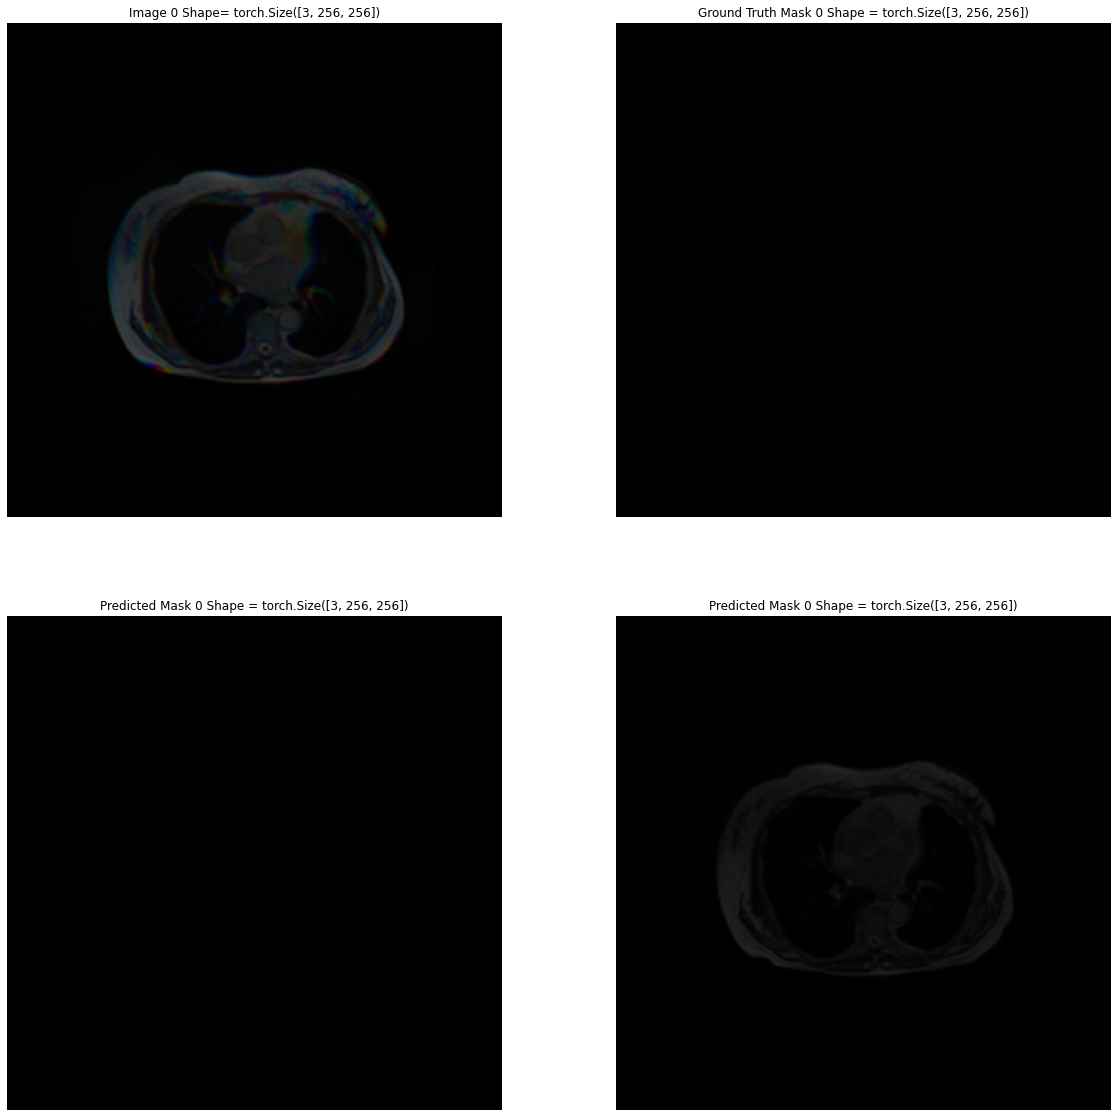

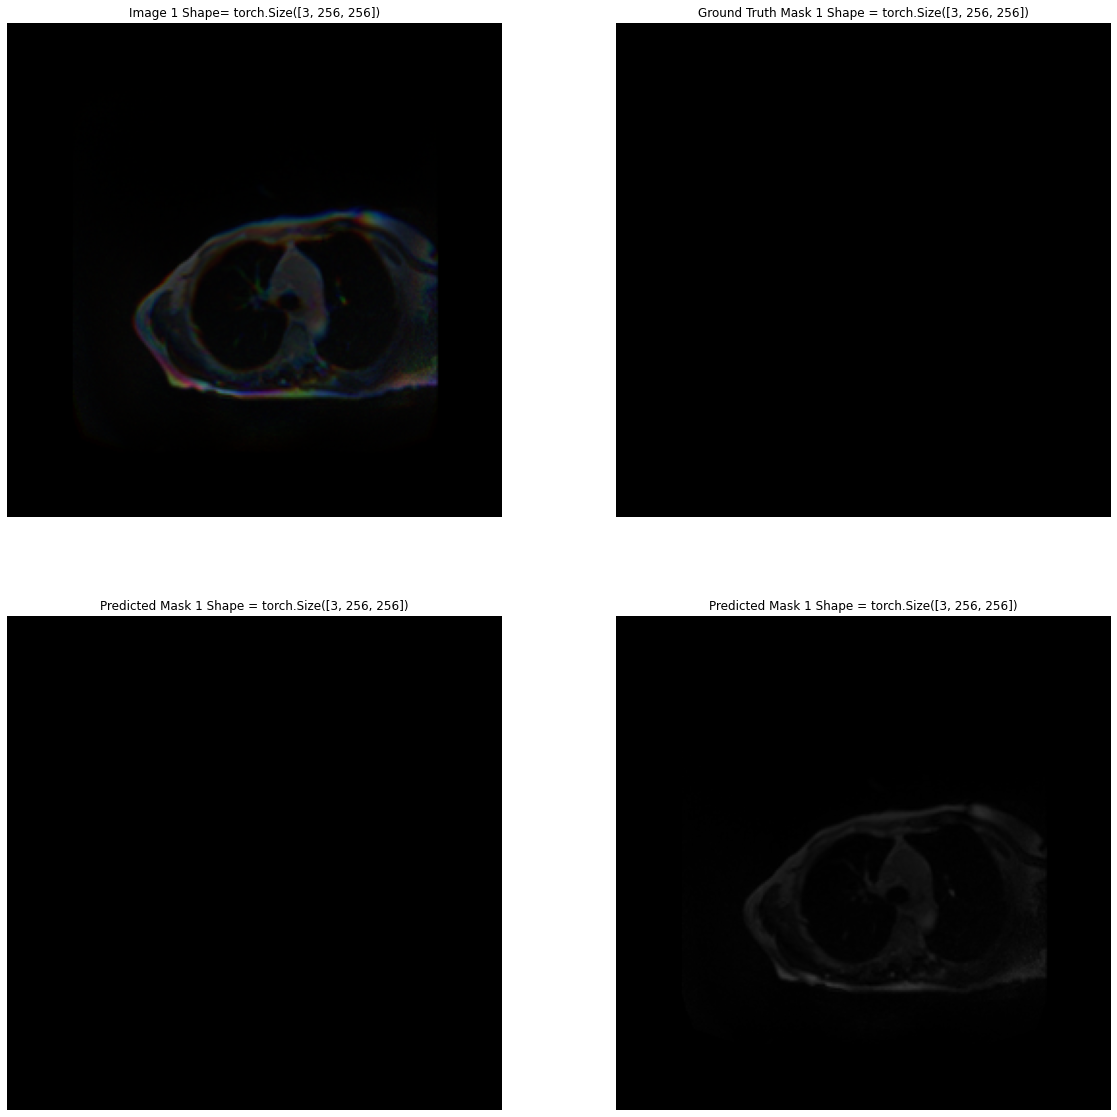

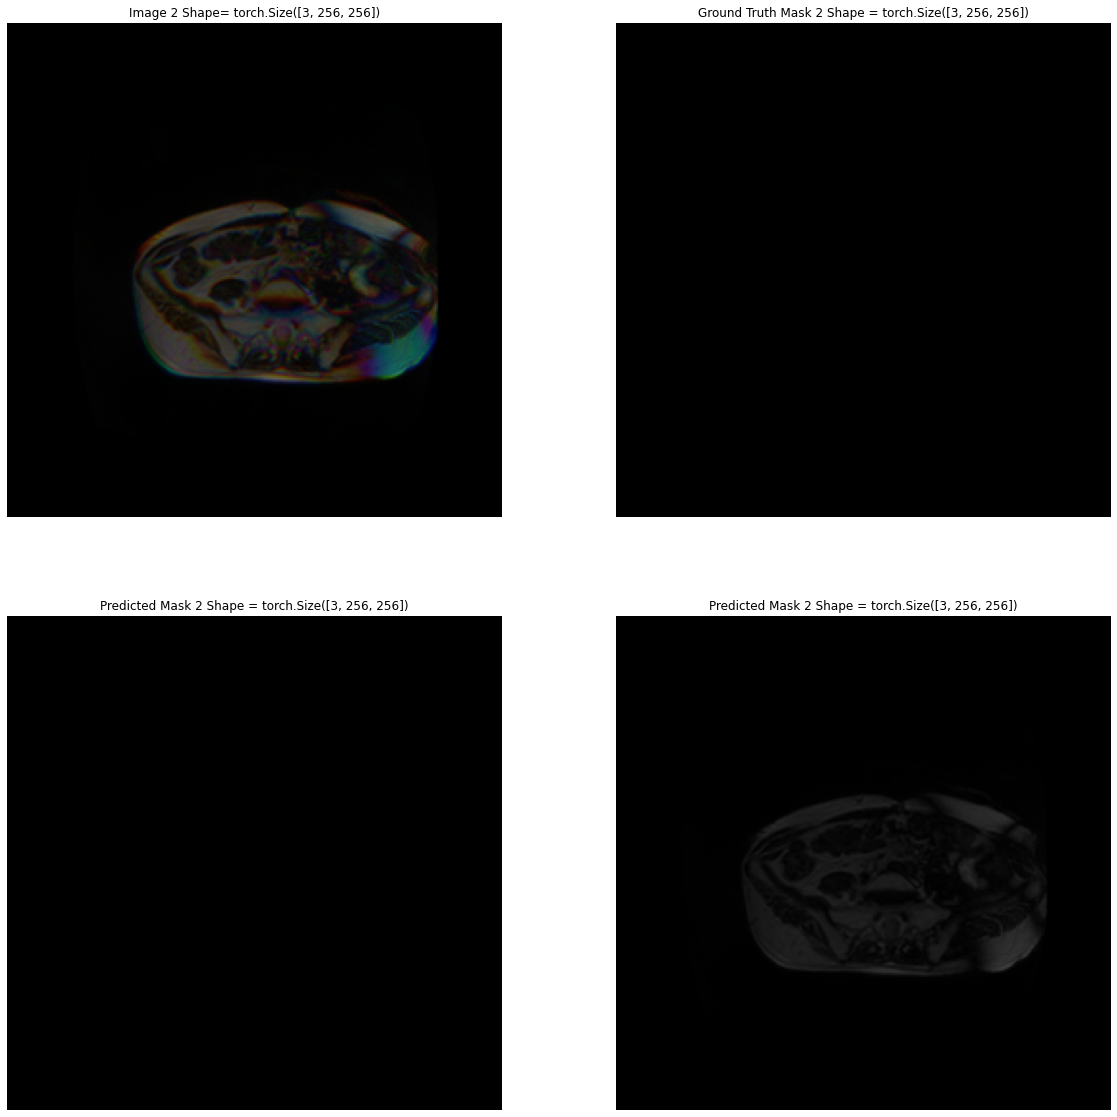

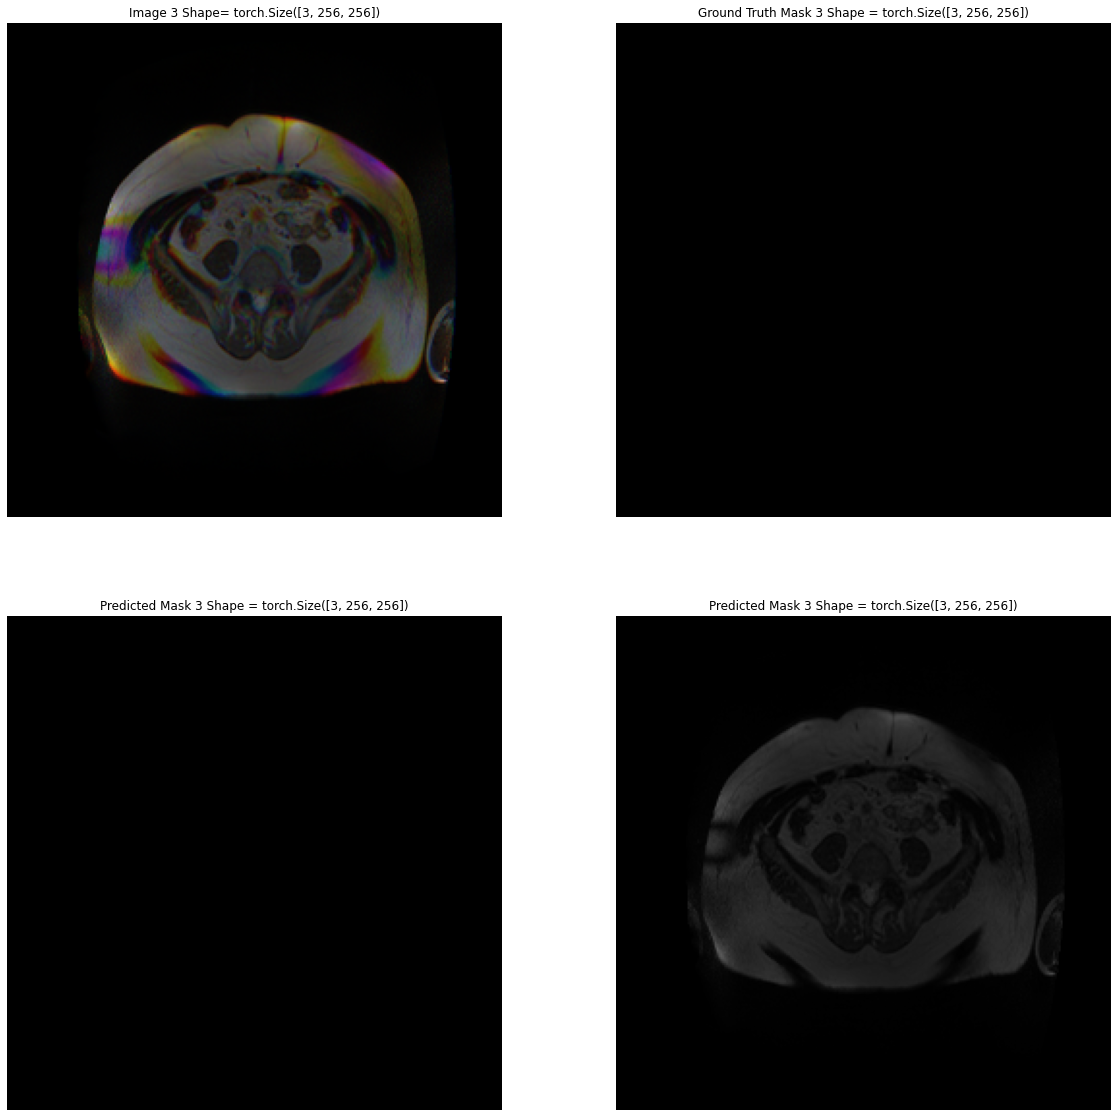

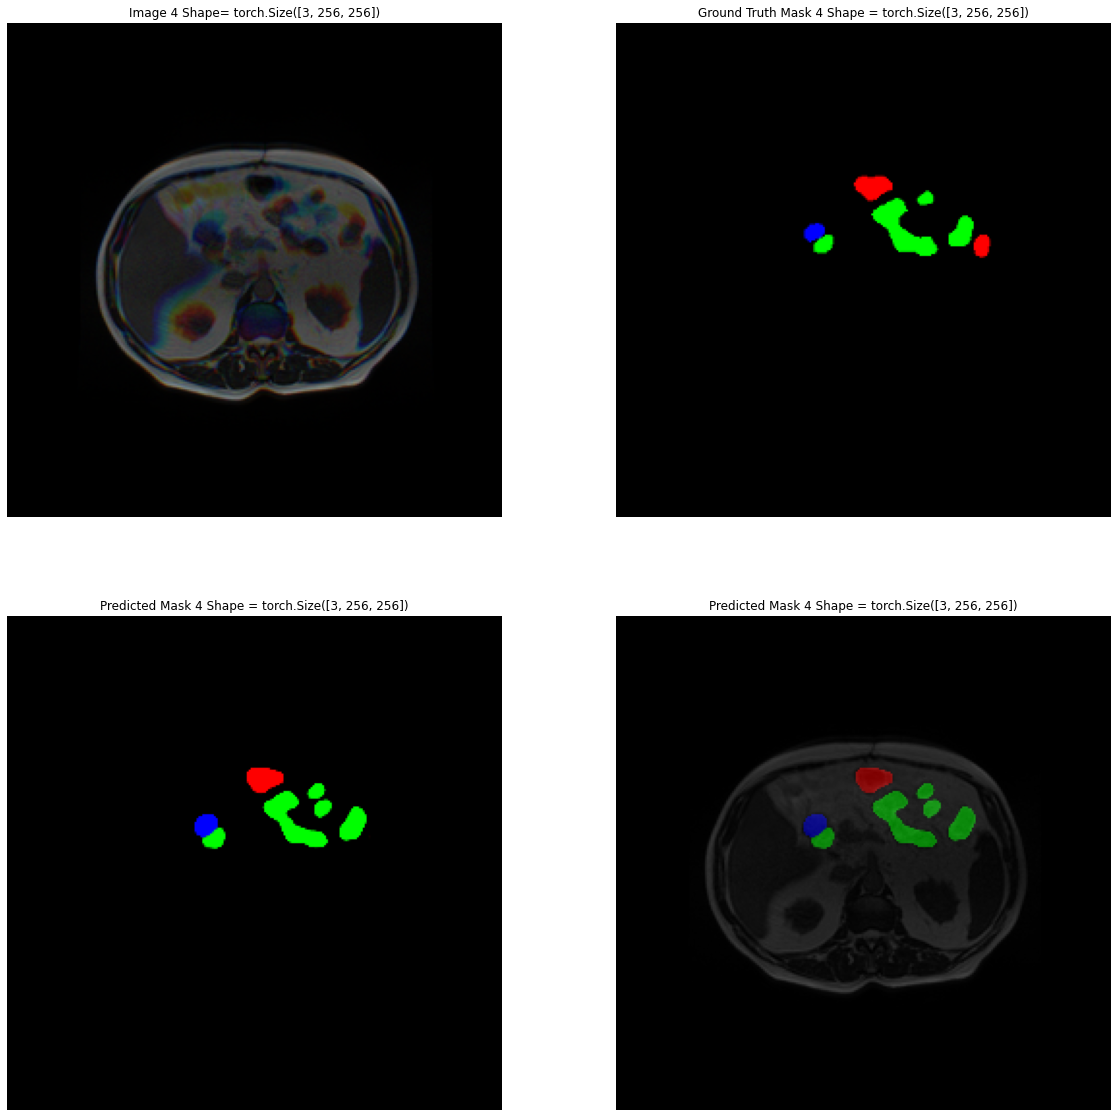

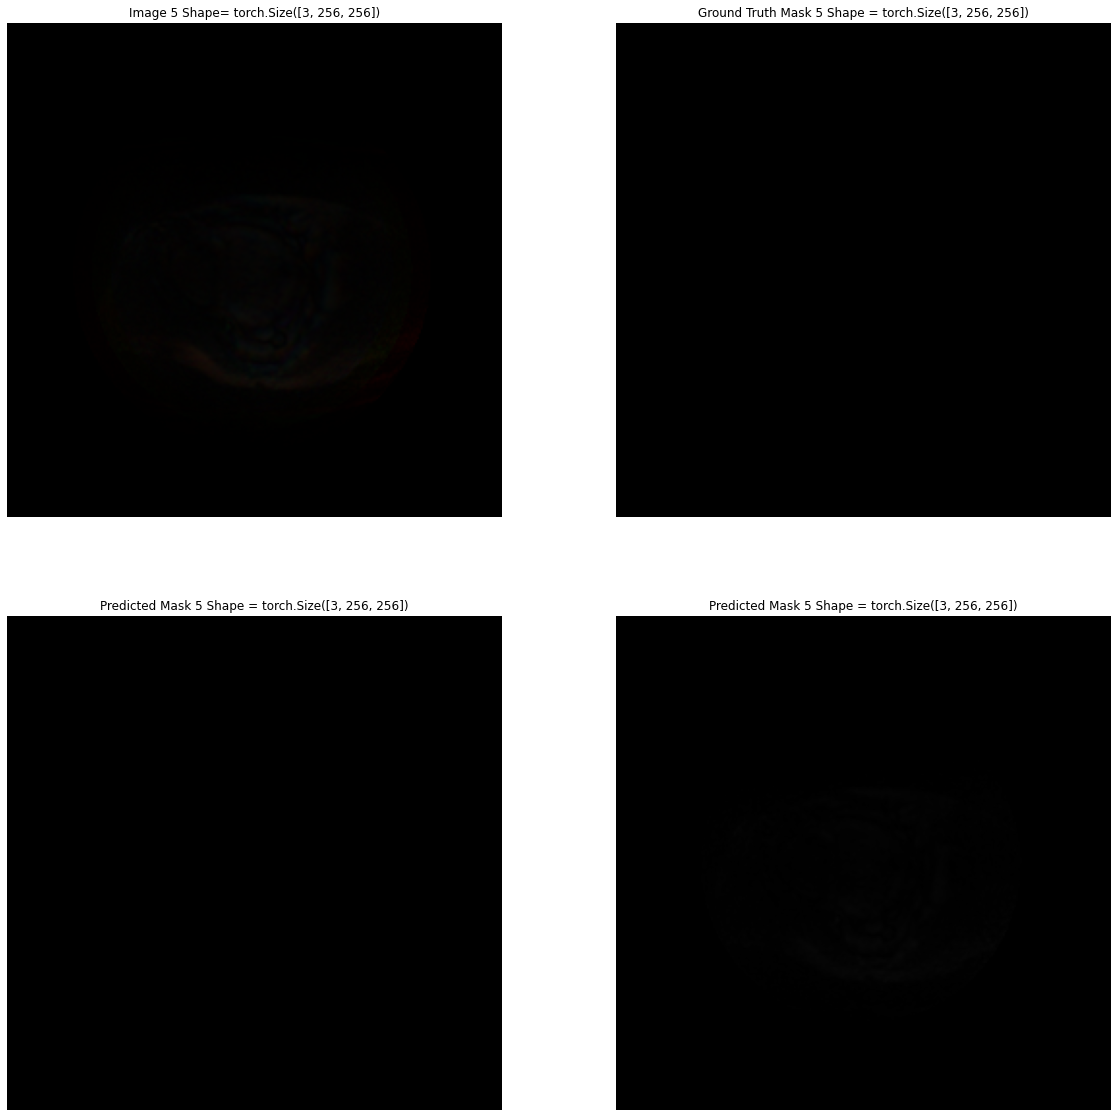

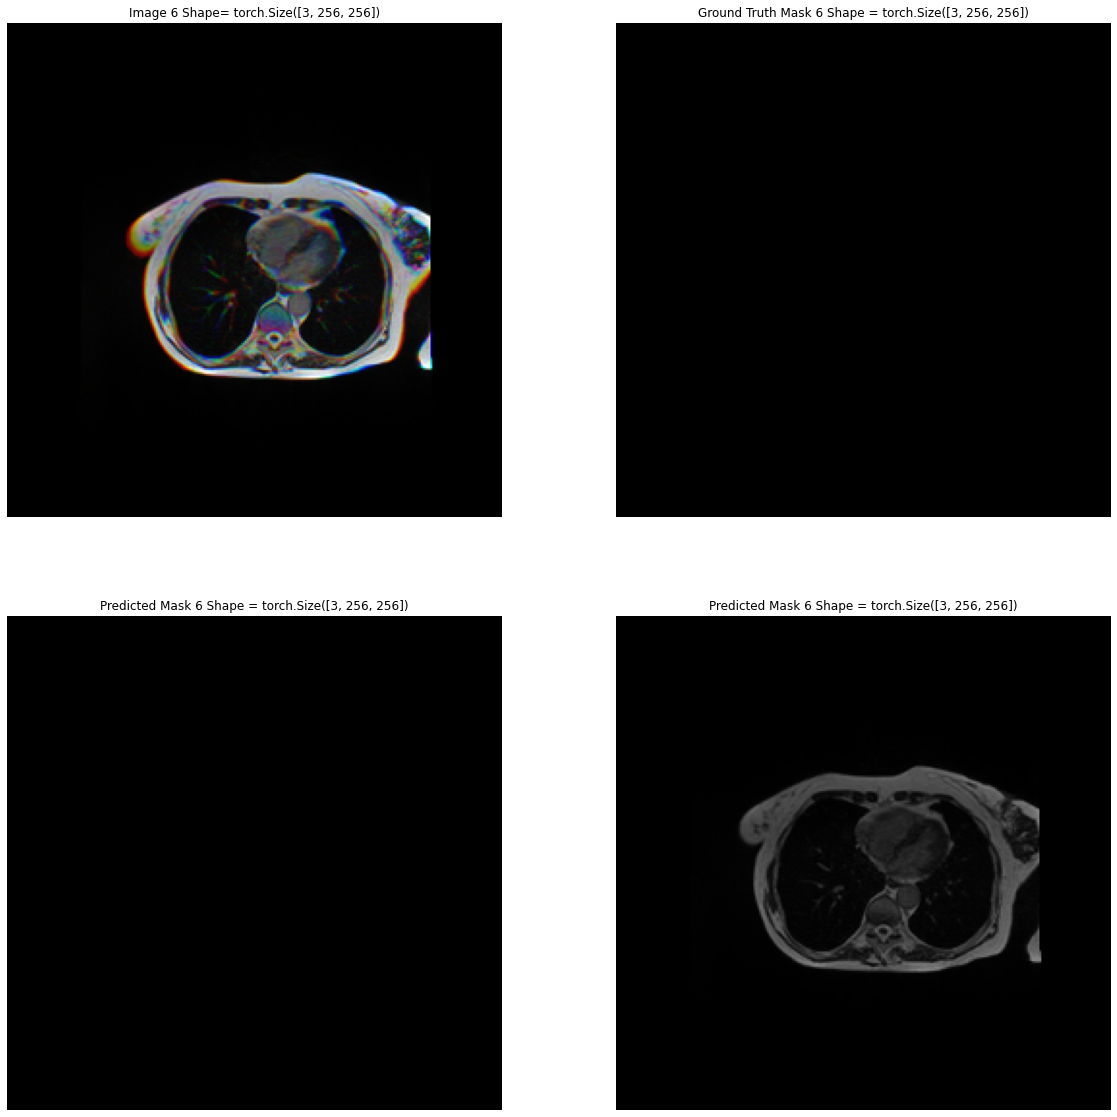

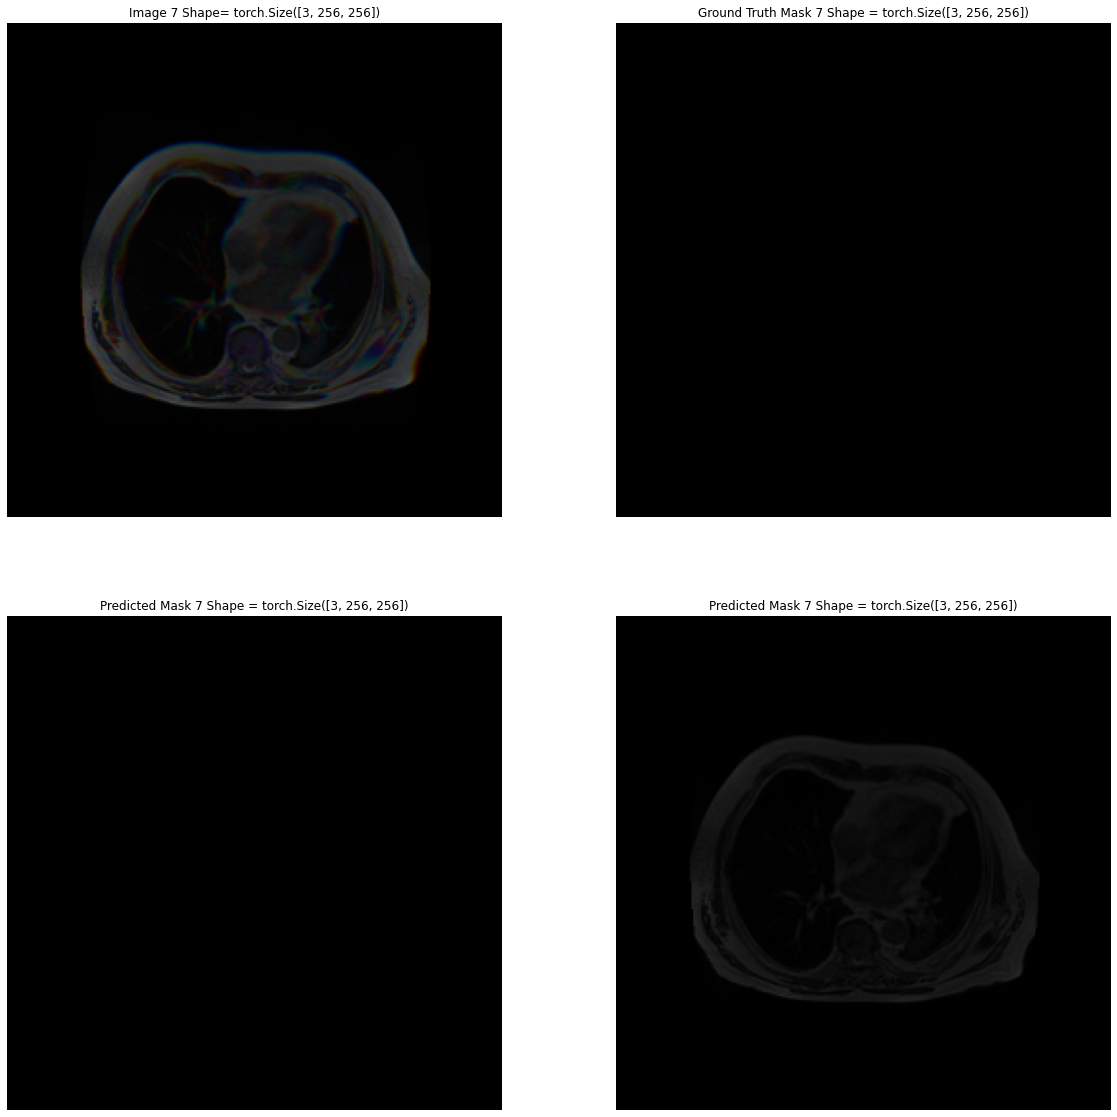

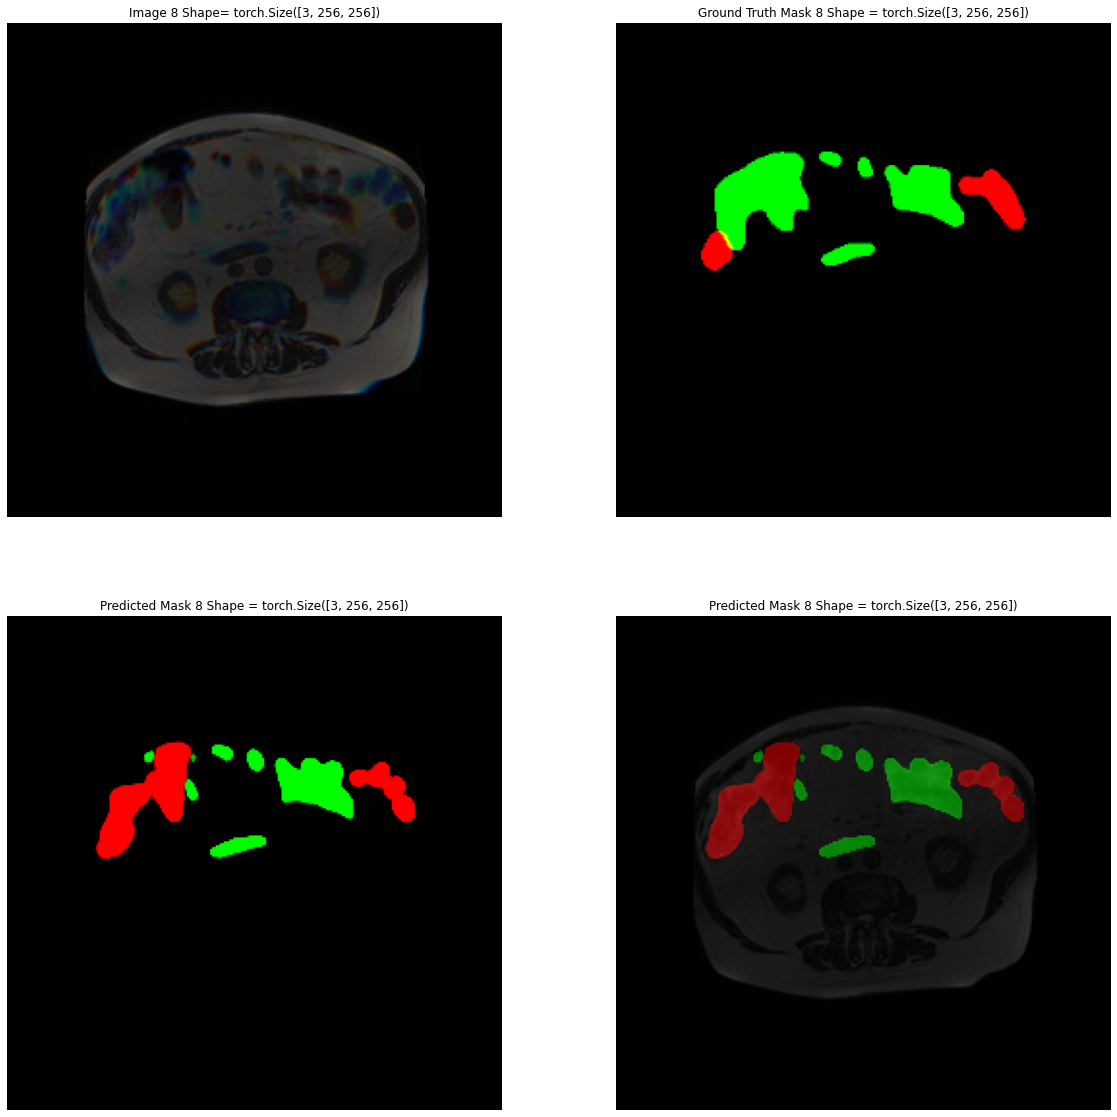

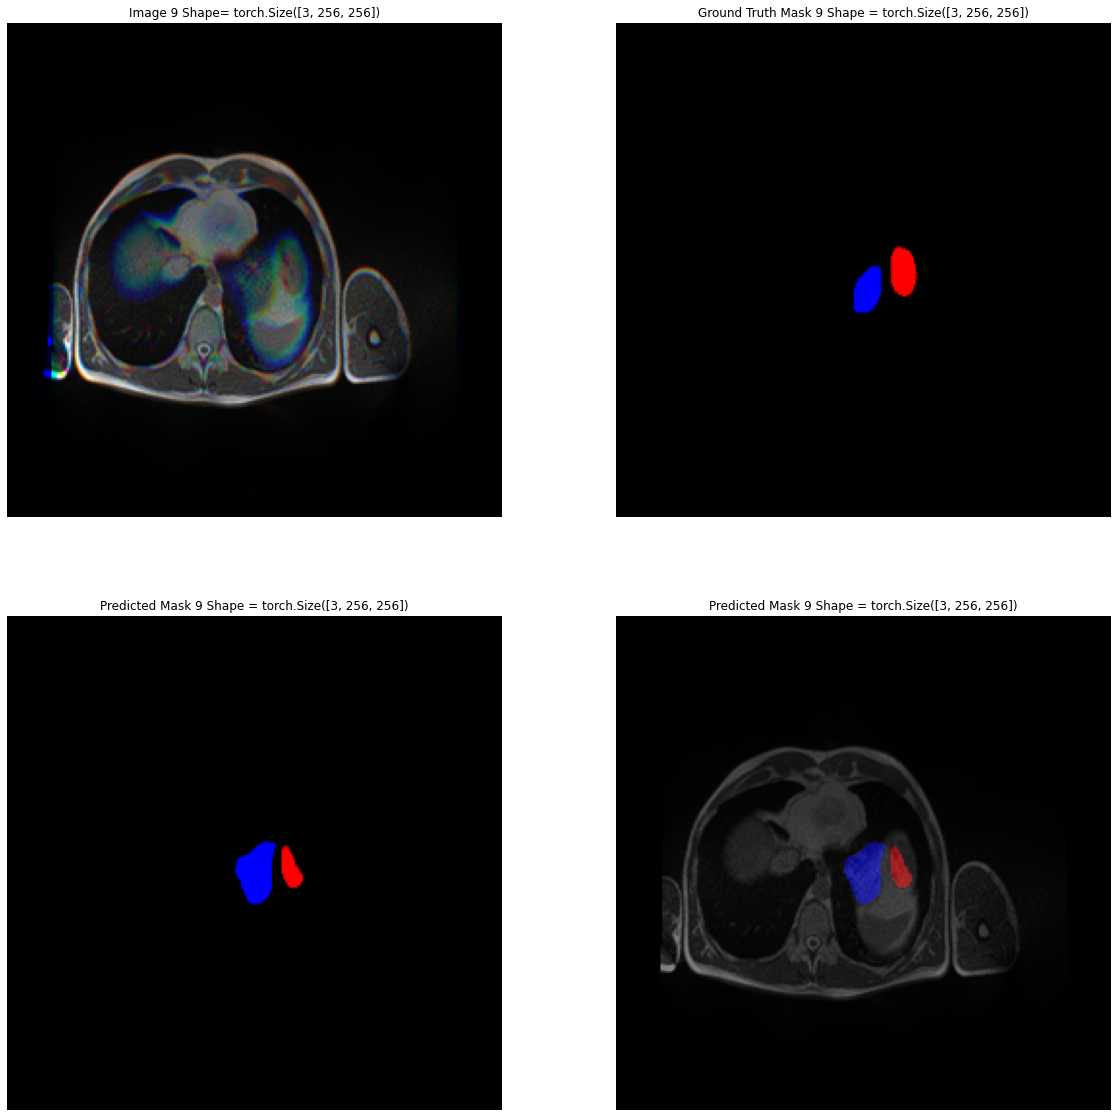

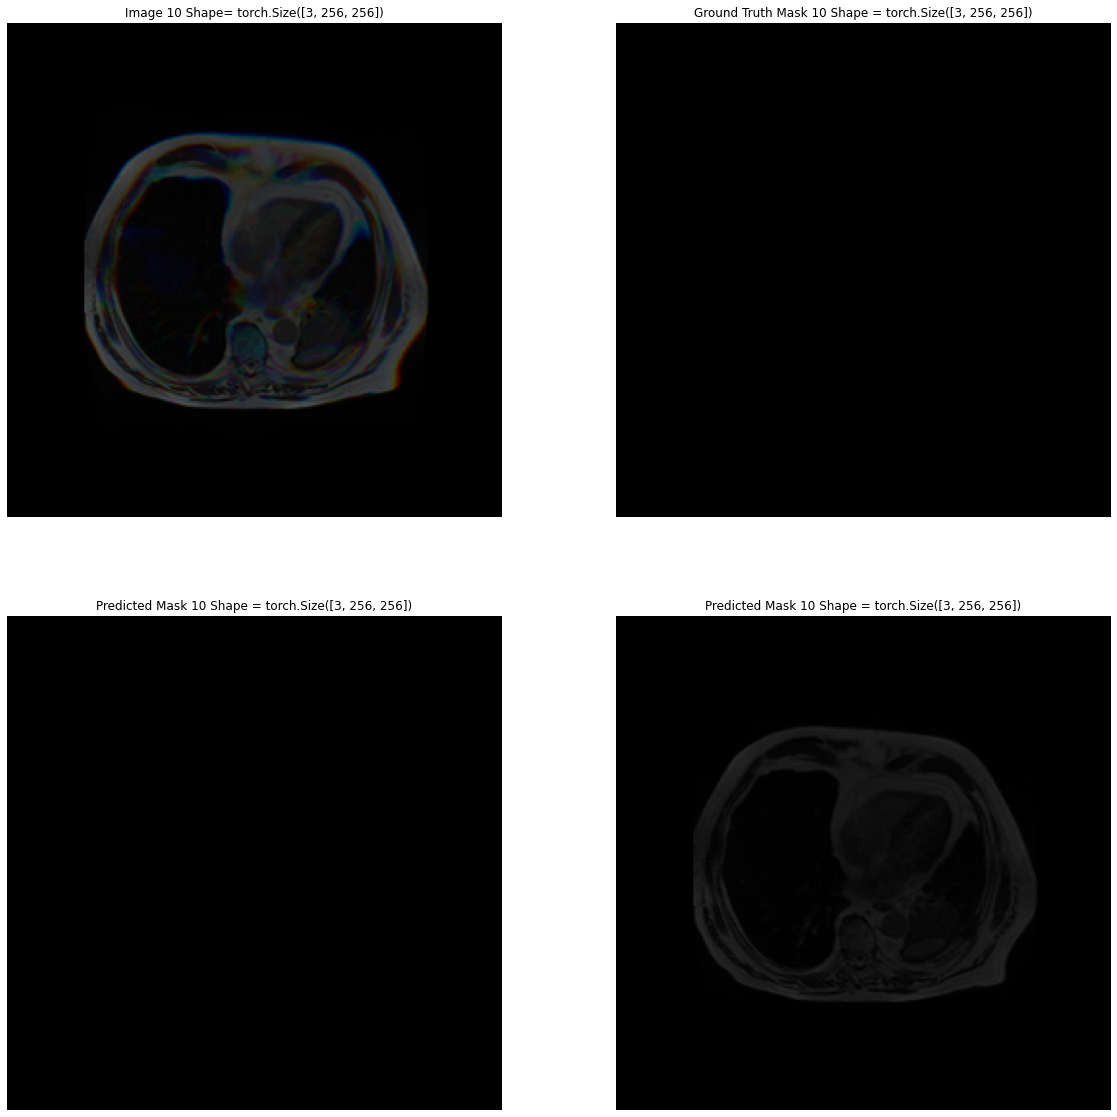

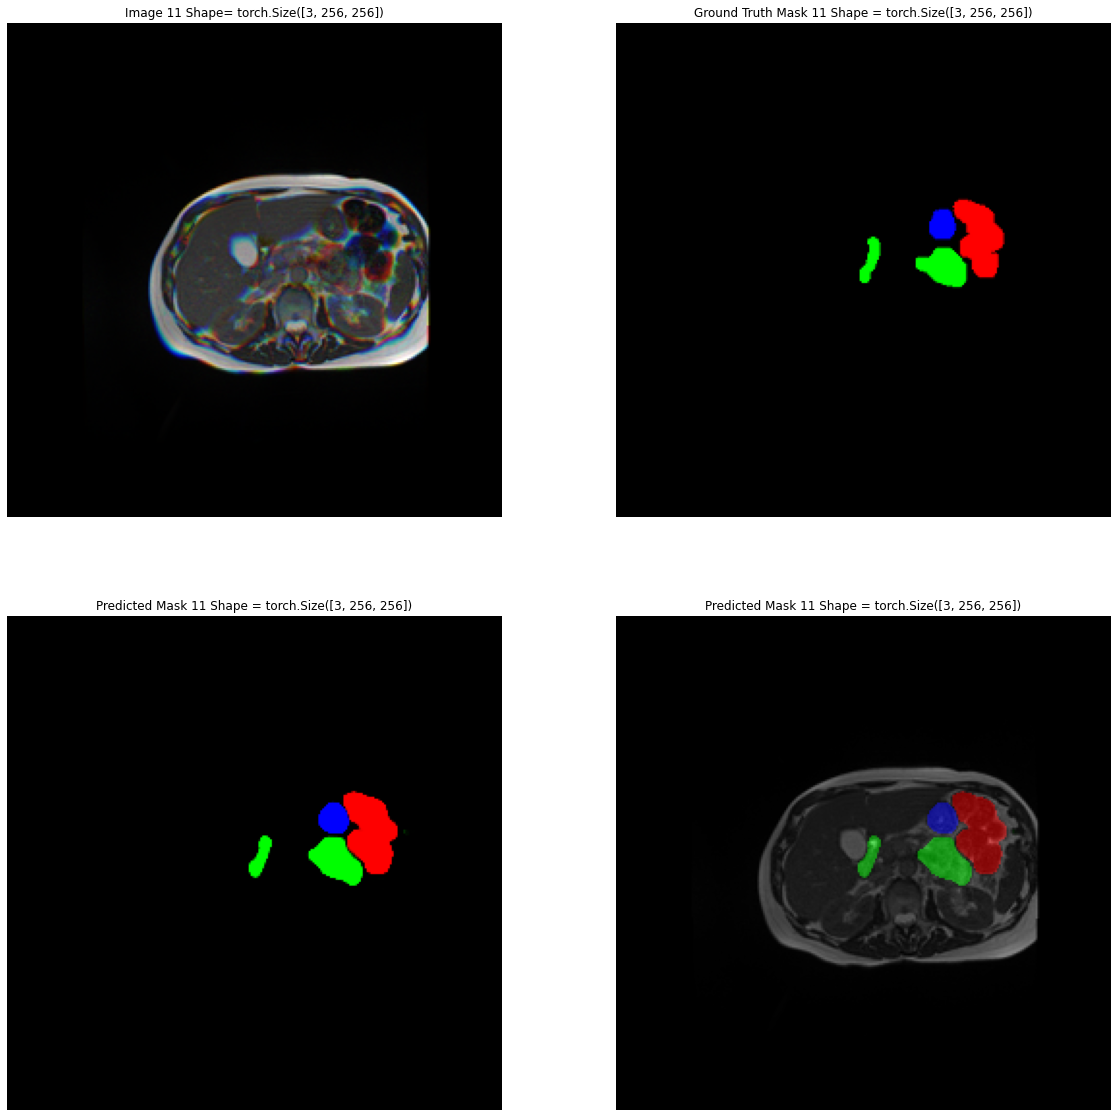

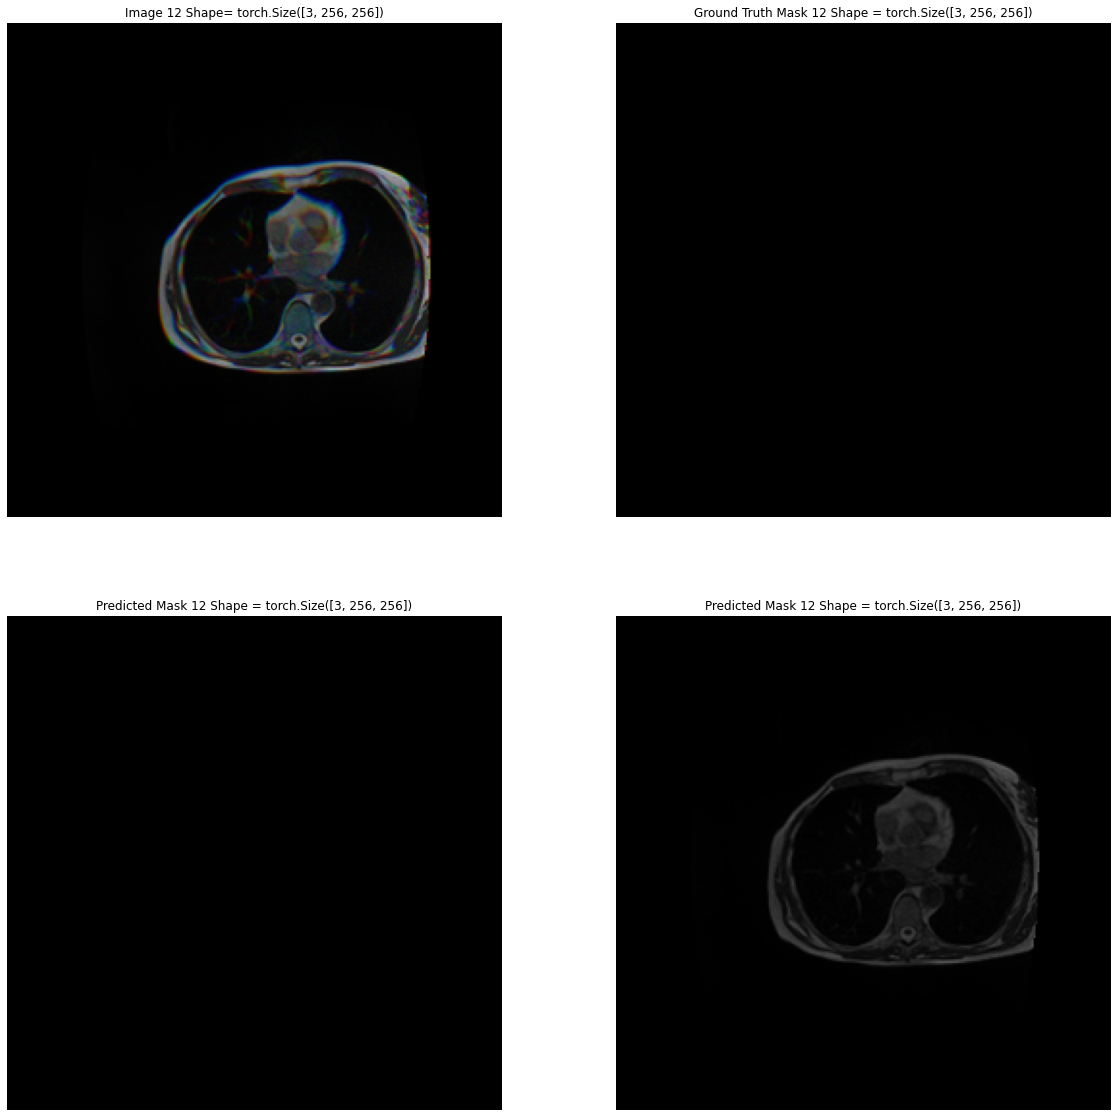

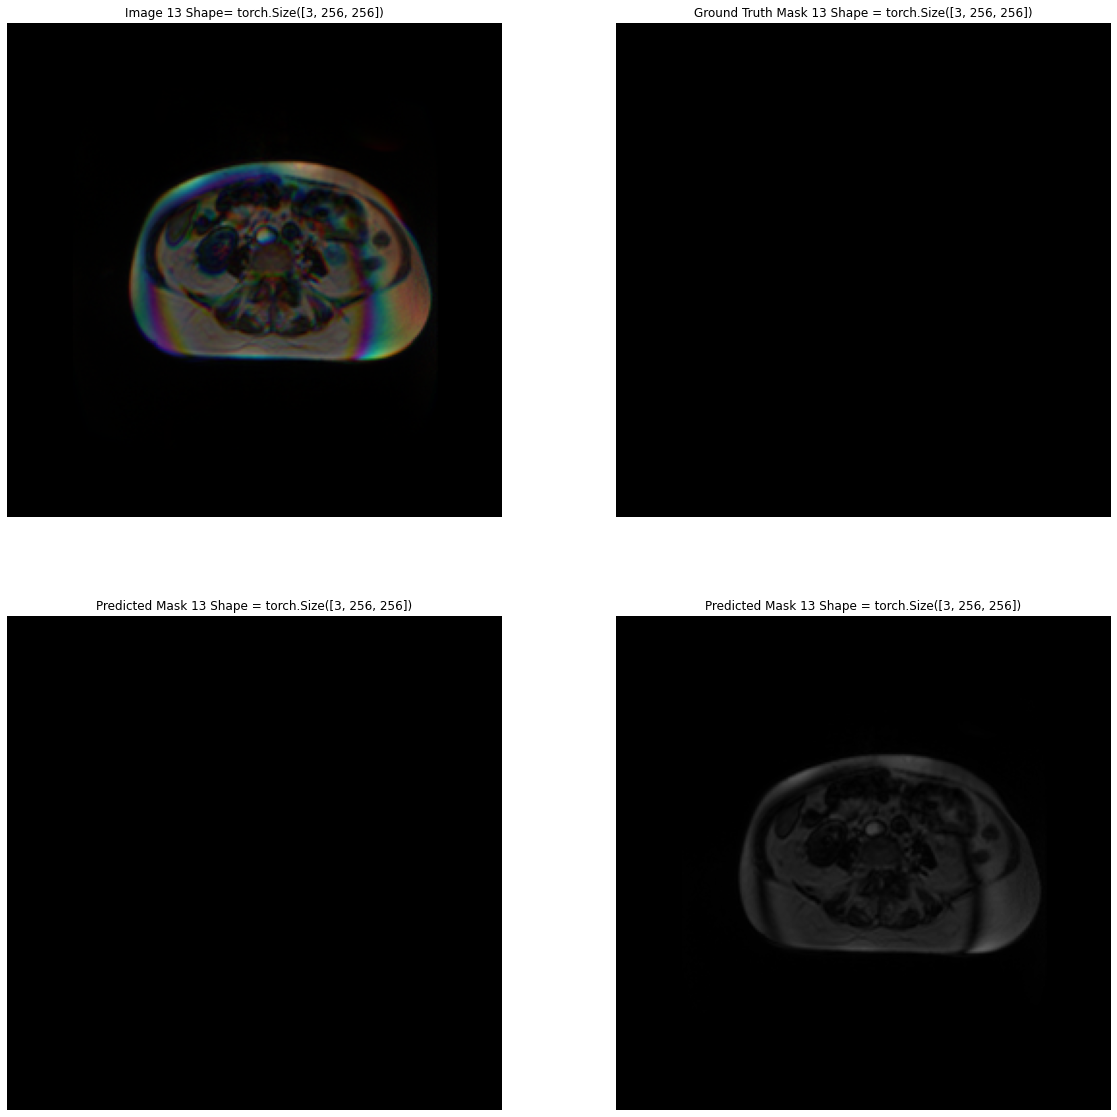

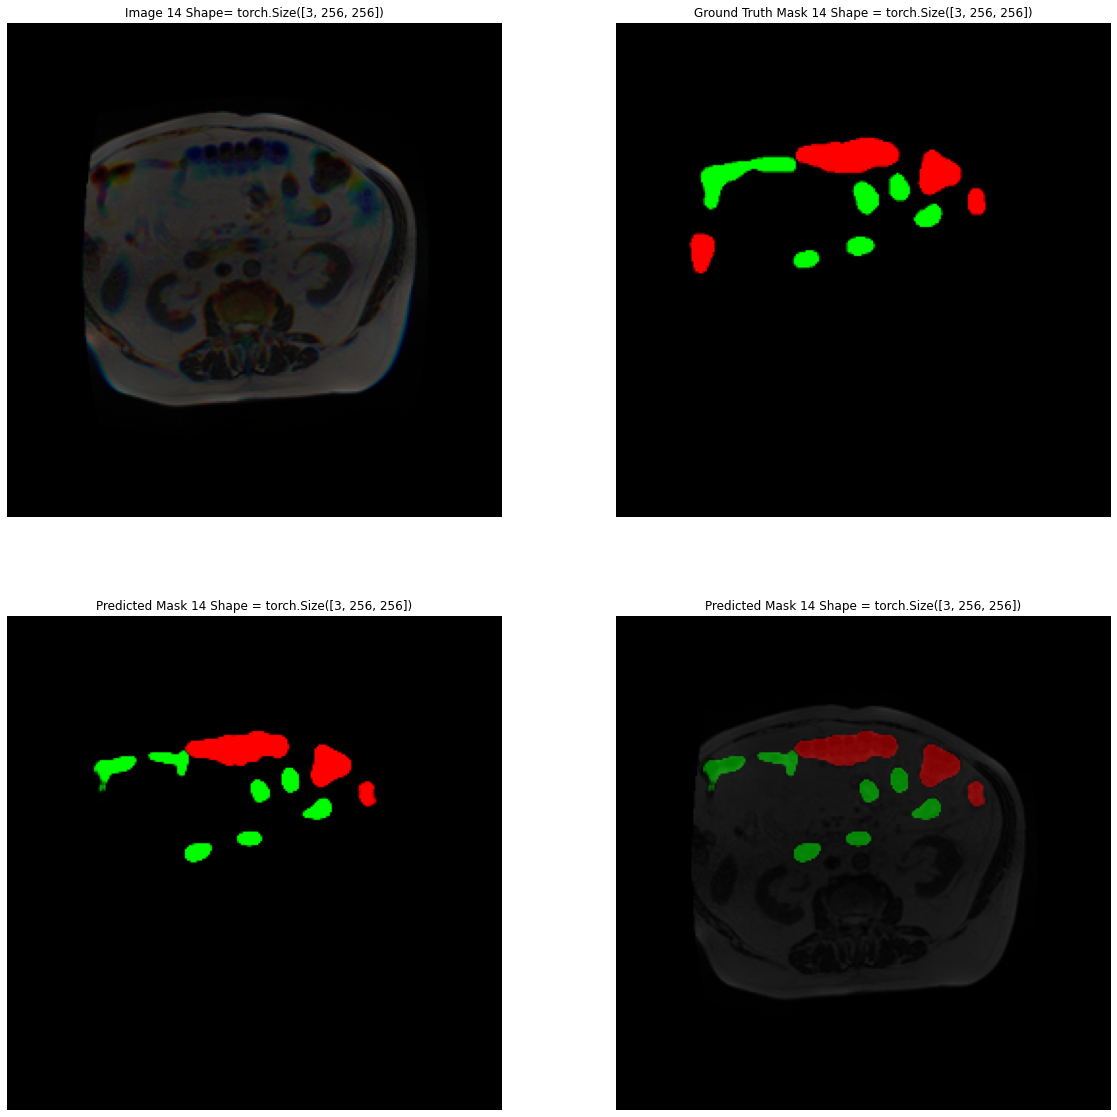

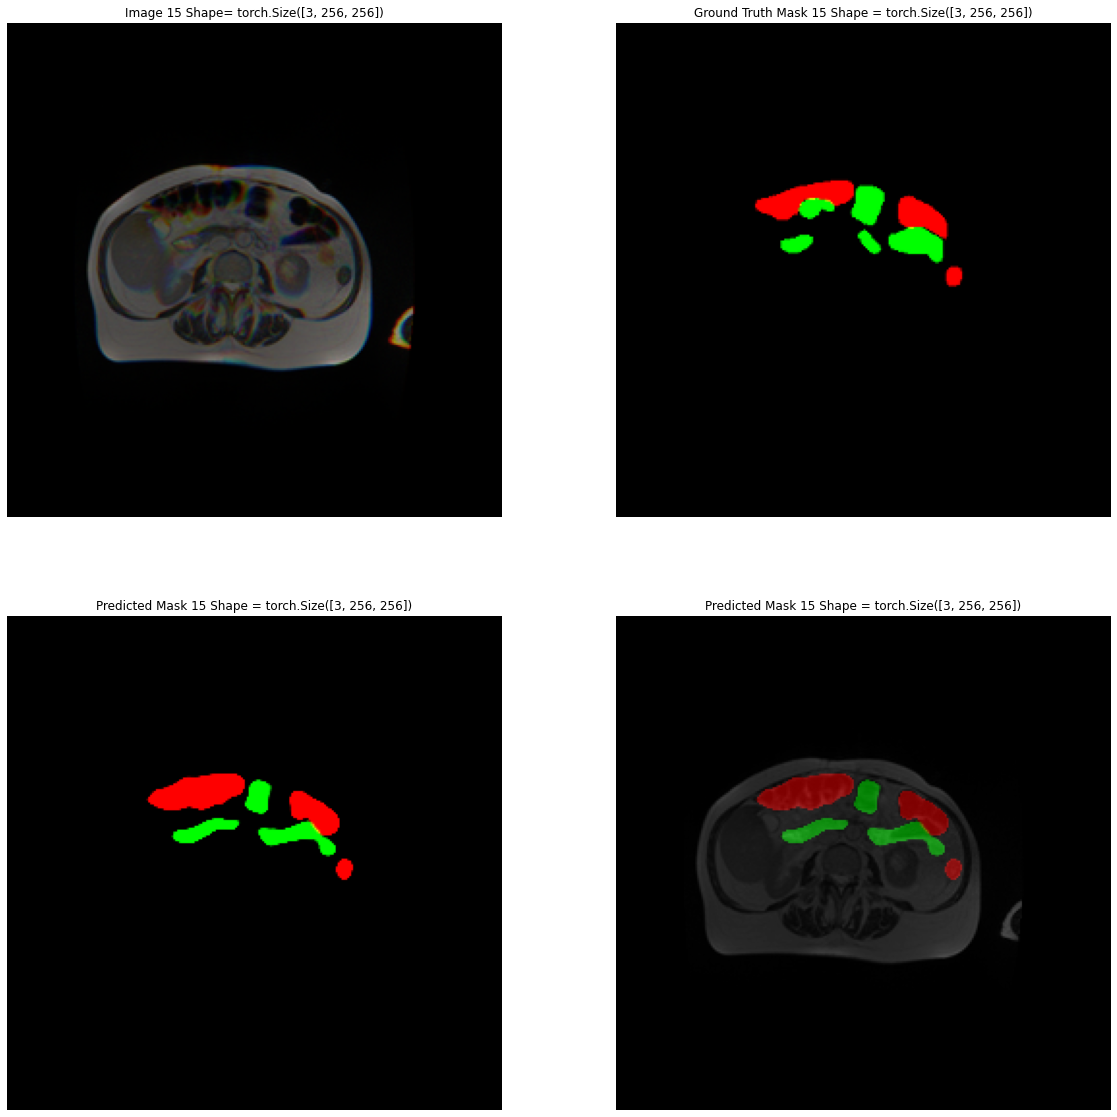

In [45]:
for idx in range(0,16):
    plot_result25(data=data, output=output, idx=idx)

## Calculate the error metrics on the validation folds

In [46]:
df25d['ilocid']=list(range(0,df25d.shape[0]))

In [47]:
def validatefp32_detail(valid_dataloader, loss_fn, metric_fn, model,res):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    
    for batch in valid_dataloader:
        images, masks, idx = batch['image'], batch['mask'], batch['idx']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        
        with torch.no_grad():
            output = model(images)
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            m_calc = metric_fn(masks,y_pred)
            metric += m_calc.sum()
            res[idx] = m_calc.cpu()
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric, res

In [48]:
def dice_coef_batch(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1))
    return dice

In [49]:
def prepare_valid_dataset(df, fold, scale_transforms):
    valid_df = df.query("fold==@fold").reset_index(drop=True)

    valid_dataset = Dataset_2_5_from_df(valid_df,TRAIN_FOLDER, joint_transform=None,
                                   image_transform=scale_transforms, mask_transform=scale_transforms,ret_idx=True)
    
    return valid_dataset

In [50]:
model_name = "Unet-6-2.pth"
loss_fn = criterion
metric_fn = dice_coef_batch
n_folds = int(df25d['fold'].max()) + 1

Return the actual file id and the metric

In [51]:

mean_metric = 0
res = torch.zeros((df25d.shape[0]))

for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="densenet121",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name) 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()

    valid_dataset = prepare_valid_dataset(df25d, fold, scale_transforms)
    

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    

        
    validation_loss, validation_metric,res = validatefp32_detail(valid_dataloader,
                                                                  loss_fn,
                                                                  metric_fn,
                                                                  model,
                                                                res)



    print('Fold-{}- Loss: {:.4f}, Metric = {:.3f}'.format(fold, validation_loss, validation_metric))
    
    
    
    
    mean_metric = mean_metric + validation_metric
    
print("Mean metric =",mean_metric/n_folds)    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-6-2.pth


  0%|          | 0/1108 [00:00<?, ?it/s]

Fold-0- Loss: 0.1150, Metric = 0.900
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-6-2.pth


  0%|          | 0/1112 [00:00<?, ?it/s]

Fold-1- Loss: 0.1190, Metric = 0.891
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-6-2.pth


  0%|          | 0/810 [00:00<?, ?it/s]

Fold-2- Loss: 0.1339, Metric = 0.888
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-6-2.pth


  0%|          | 0/896 [00:00<?, ?it/s]

Fold-3- Loss: 0.0910, Metric = 0.921
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-6-2.pth


  0%|          | 0/886 [00:00<?, ?it/s]

Fold-4- Loss: 0.1137, Metric = 0.910
Mean metric = tensor(0.9021, device='cuda:0')


In [52]:
df25d['dice'] = res.numpy()

In [53]:
df25d.columns

Index(['large_bowel', 'small_bowel', 'stomach', 'id', 'case_id_str', 'case_id',
       'day_num_str', 'day_num', 'slice_id', 'slice_num', 'match', 'subpath',
       'filename', 'im_height', 'im_width', 'im_pixel_height',
       'im_pixel_width', 'slice_thickness', 'segmentations', 'fold', 'max',
       'max_img', 'subpath_00', 'subpath_01', 'subpath_02', 'subpaths',
       'ilocid', 'dice'],
      dtype='object')

In [54]:
df25d.to_csv(DATASET_FOLDER/"results/df25d_6-2.csv")

<AxesSubplot:xlabel='im_width', ylabel='dice'>

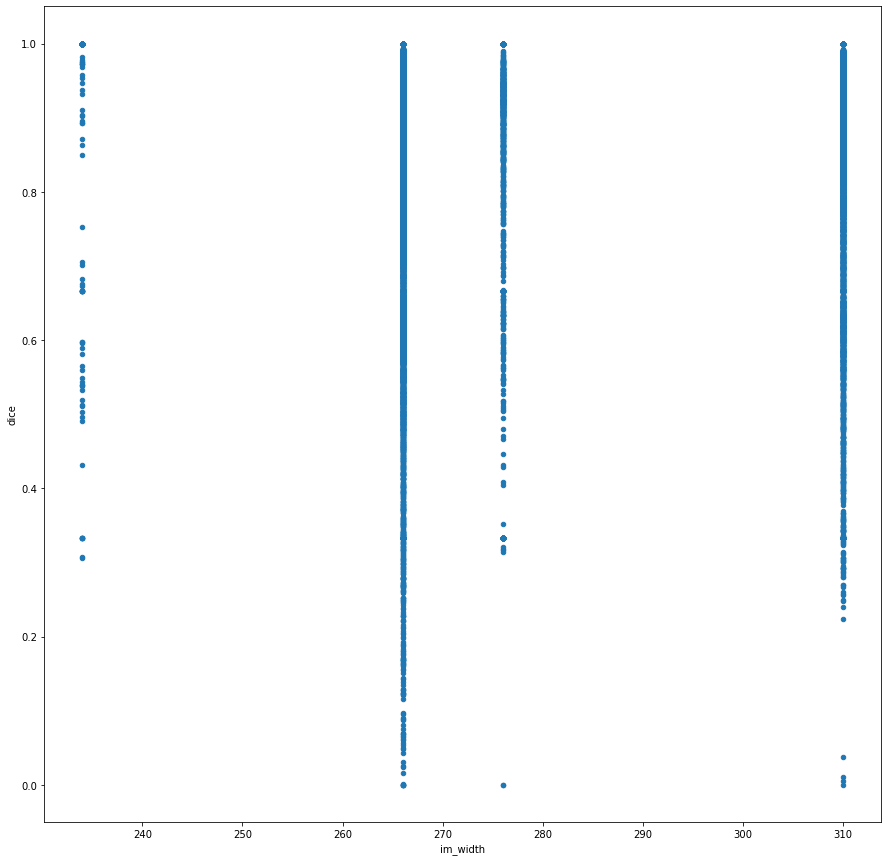

In [55]:
df25d.plot(x='im_width',y='dice',kind='scatter',figsize=(15,15))

array([<AxesSubplot:title={'center':'234'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'266'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'276'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'310'}, ylabel='Frequency'>],
      dtype=object)

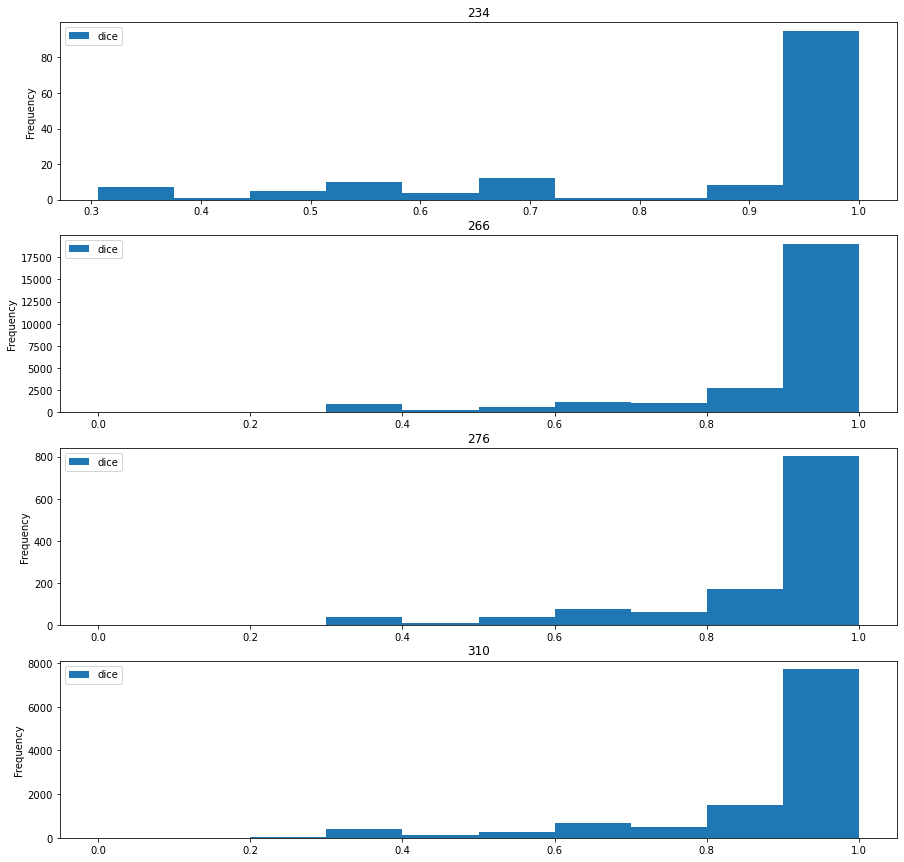

In [56]:
df25d.plot.hist(column='dice',by=['im_width'],figsize=(15,15))

In [57]:
df = pd.DataFrame(df25d.groupby("slice_num")["dice"].mean())

In [58]:
list(df['dice'])

[0.9987834692001343,
 0.9979605674743652,
 0.9986000061035156,
 0.9986363649368286,
 0.9993030428886414,
 0.9998732209205627,
 0.9998379945755005,
 0.9949001669883728,
 0.9958158135414124,
 0.9969711303710938,
 0.9962195158004761,
 0.9972786903381348,
 0.9964078068733215,
 0.9943687319755554,
 0.9953638315200806,
 0.9938452243804932,
 0.9945651292800903,
 0.9938471913337708,
 0.9976192116737366,
 0.9952062964439392,
 0.9926360845565796,
 0.9939658045768738,
 0.9955543279647827,
 0.9886598587036133,
 0.9873863458633423,
 0.9894591569900513,
 0.9896349906921387,
 0.9892927408218384,
 0.990005373954773,
 0.9923304915428162,
 0.9895533919334412,
 0.9855836033821106,
 0.9837215542793274,
 0.981040894985199,
 0.9782043099403381,
 0.9728173613548279,
 0.9772759079933167,
 0.976273238658905,
 0.9818671941757202,
 0.9771599769592285,
 0.9703337550163269,
 0.9642541408538818,
 0.960421621799469,
 0.960551917552948,
 0.951869010925293,
 0.9506009221076965,
 0.9538182616233826,
 0.9554725885391235

In [59]:
torch.cuda.empty_cache()

In [ ]:
train_dataset[0]

In [ ]:
del output